# Getting Started

## Welcome to Ocelli!

*Ocelli (singular Ocellus, Latin: little eye) – simple eyes found in many insects in triplets. Their function is to navigate insects during the day or to detect movement.*

Ocelli is an open-source Python library with computational tools for exploring multimodal single-cell developmental data. It includes tools for preprocessing, analysis, and plotting low dimensional embeddings. Ocelli's functionality comprises:

- finding nearest neighbors, 
- Multimodal Diffusion Maps algorithm for modeling multimodal developmental processes,
- reducing data dimensionality using ForceAtlas2 and UMAP,
- calculating marker signature's z-scores,
- plotting 2D and interactive 3D plots.

Thanks to being integrated with the standard AnnData data structure and using scanpy-like syntax, Ocelli can be easily added to your familiar single-cell analysis pipelines.

These tutorials introduce a spectrum of Ocelli’s functionality and applications. Ocelli is designed for analyzing multimodal data when each cell has entries from each modality. Firstly, we will work on simulated data to build intuition. We will then proceed to single-cell multimodal data from human bone marrow and hair follicle - including modalities such as chromatin accessibility, gene expression, or protein. Lastly, we will share a new perspective on analyzing unimodal data based on pancreatic endocrinogenesis and cell reprogramming data. Let’s go!

## Learning Objectives

After this tutorial, you should be able to:
    
- explore single-cell developmental multimodal data,
- understand the benefits of joint analysis and visualization of multimodal data,
- construct Multimodal Diffusion Maps embeddings of simulated and experimental data and visualize them using Ocelli.

**Note**: This is the first tutorial, which is an introduction based on simulated data. Analysis of single-cell data is discussed in subsequent tutorials.

## Simulated data I

Modality, in general, refers to an experimentally measured genome-wide feature. For example, RNA-seq is the transcriptome's single-cell modality, represented by a cell-by-gene count matrix encoding gene expression. The higher the value in the count matrix, the more expressed a gene is in a cell. However, a wide range of biological information is lost when analyzing only a transcriptome. A simplistic version of the *central dogma of molecular biology* states that *DNA makes RNA, and RNA makes protein*. As a result, when looking solely at RNA levels, you omit molecular information hidden in DNA and protein. DNA and protein are other modalities that may contribute information unavailable in RNA. Suppose you intend to understand molecular biological processes. In that case, you need to be able to interpret such multimodal signals together, not individually.

To build your intuition, we prepared simulated data, which is easy to interpret and visualize. Firstly, we will explore it unimodally.

Import Ocelli as

In [1]:
import ocelli as oci

We shorten the imported name to ``oci`` for better code readability using Ocelli. 
Ocelli has three modules: ``oci.pp`` (data preprocessing), ``oci.tl`` (analysis tools), and ``oci.pl`` (plotting).
The workflow typically consists of multiple function calls on an ``anndata.AnnData`` object.

Ocelli can produce static plots using [Matplotlib](https://matplotlib.org) or interactive plots using [Plotly](https://plotly.com/python/).
``oci.pl`` functions return Matplotlib ``Figure`` and ``Axes`` objects or a Plotly ``Figure`` object that you can further customize. 
The presented tutorials will show only static Matplotlib plots due to the incompatibility issues between interactive Plotly plots and the online documentation. However, we prepared some 3D plots, which are available for download on [GitHub](https://github.com/TabakaLab/ocelli/tree/dev/html) (they will be referenced later on).

Set Matplotlib figure resolution of shown plots.

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

Some Ocelli functions include probabilistic steps. We set a random seed for the sake of reproducibility. If you omit this step, each run will result in marginally different outcomes, which is a natural effect in stochastic processes. Note that setting a seed may result in different outcomes when code is run on different processors.

In [3]:
SEED = 17

Now, load the data. 

In [4]:
import anndata
from os.path import join

# a path to the folder with data
folder_path = '../../../data/simulated_data_i'

adata = anndata.read_h5ad(join(folder_path, 'binary-tree-dataset.h5ad'))
adata

AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'type', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1', 'modality2'

Ocelli uses an annotated data structure called [AnnData](https://anndata.readthedocs.io). If you're unfamiliar with it, we recommend glancing at its linked documentation. Here, we load a h5ad file storing an AnnData object with three modalities ``modality0``, ``modality1``, and ``modality2`` saved in ``adata.obsm``. Each modality is an array with rows corresponding to observations and columns to features. Note that *i*-th row in all modalities corresponds to the same observation. In this particular dataset, observations form a half of a binary tree with three branching points - each visible in a separate modality. Modalities are 3-dimensional for quick, intuitive visualizations, that would be impossible for high-dimensional single-cell data.

In [5]:
adata.obsm['modality0'].shape, adata.obsm['modality1'].shape, adata.obsm['modality2'].shape

((6000, 3), (6000, 3), (6000, 3))

``adata.uns['modalities']`` specifies which ``adata.obsm`` arrays are modalities.

In [6]:
adata.uns['modalities']

array(['modality0', 'modality1', 'modality2'], dtype=object)

``adata.obs`` is a ``pandas.DataFrame`` with metadata for observations. Here, observations are grouped into types (``adata.obs['type']``) and are ordered along a developmental pseudotime (``adata.obs['pseudotime']``). As you see, there are 6000 observations. ``adata.var``, analogically, stores metadata for variable features. However, for this dataset, we do not use it.

In [7]:
adata.obs

type  pseudotime
0       A           0
1       A           1
2       A           2
3       A           3
4       A           4
...   ...         ...
5995    F        2995
5996    F        2996
5997    F        2997
5998    F        2998
5999    F        2999

[6000 rows x 2 columns]

Now, visualize each of the 3D modalities in two ways: as a 3D Plotly plot (available for download [here](https://github.com/TabakaLab/ocelli/tree/dev/html/simulated_data_i)) and a 2D Matplotlib projection. Notice how each modality introduces a new branching point. Observations are colored according to observations' ``type``.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

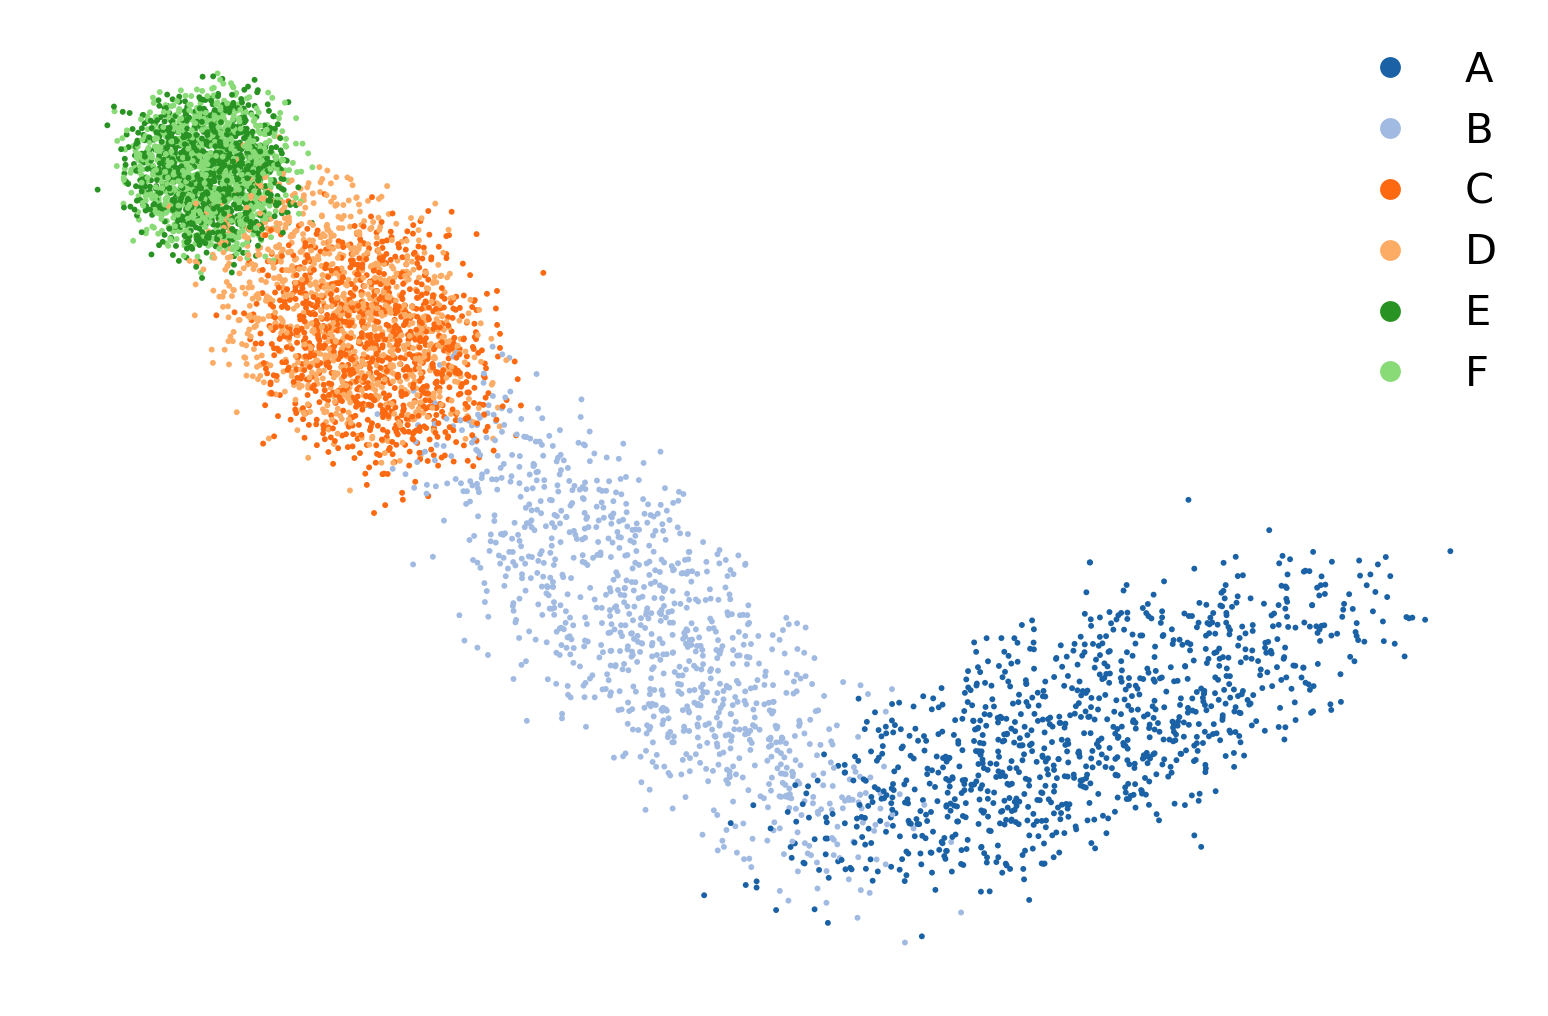

In [8]:
# Generate 3D plot
plot = oci.pl.scatter(adata, x_key='modality0', color_key='type', marker_size=3, method='plotly', axes_visible=True)
# Save it as a html file
plot.write_html(join(folder_path, 'Modality 0 type.html'))

# Create a Matplotlib colormap (optional)
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#1a62a5', '#a0bae2', '#fd6910', '#fdac65', '#289322', '#89db77'], N=256)
# Create a 2D projection
oci.tl.project_2d(adata, x_key='modality0', output_key='modality0_proj', alpha=45, beta=45)
# Generate 2D plot
oci.pl.scatter(adata, x_key='modality0_proj', color_key='type', marker_size=2, cmap=cmap, fontsize=10)

Notice that only types A and B are well-separated in this modality. Types C, D, and E, F are mixed up. When looking only at ``modality0``, it is impossible to understand the structure of the underlying developmental process beyond A and B observations.

Observations are ordered according to a ``pseudotime``. The developmental process begins at the branching point of A and B types and proceeds further. 

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

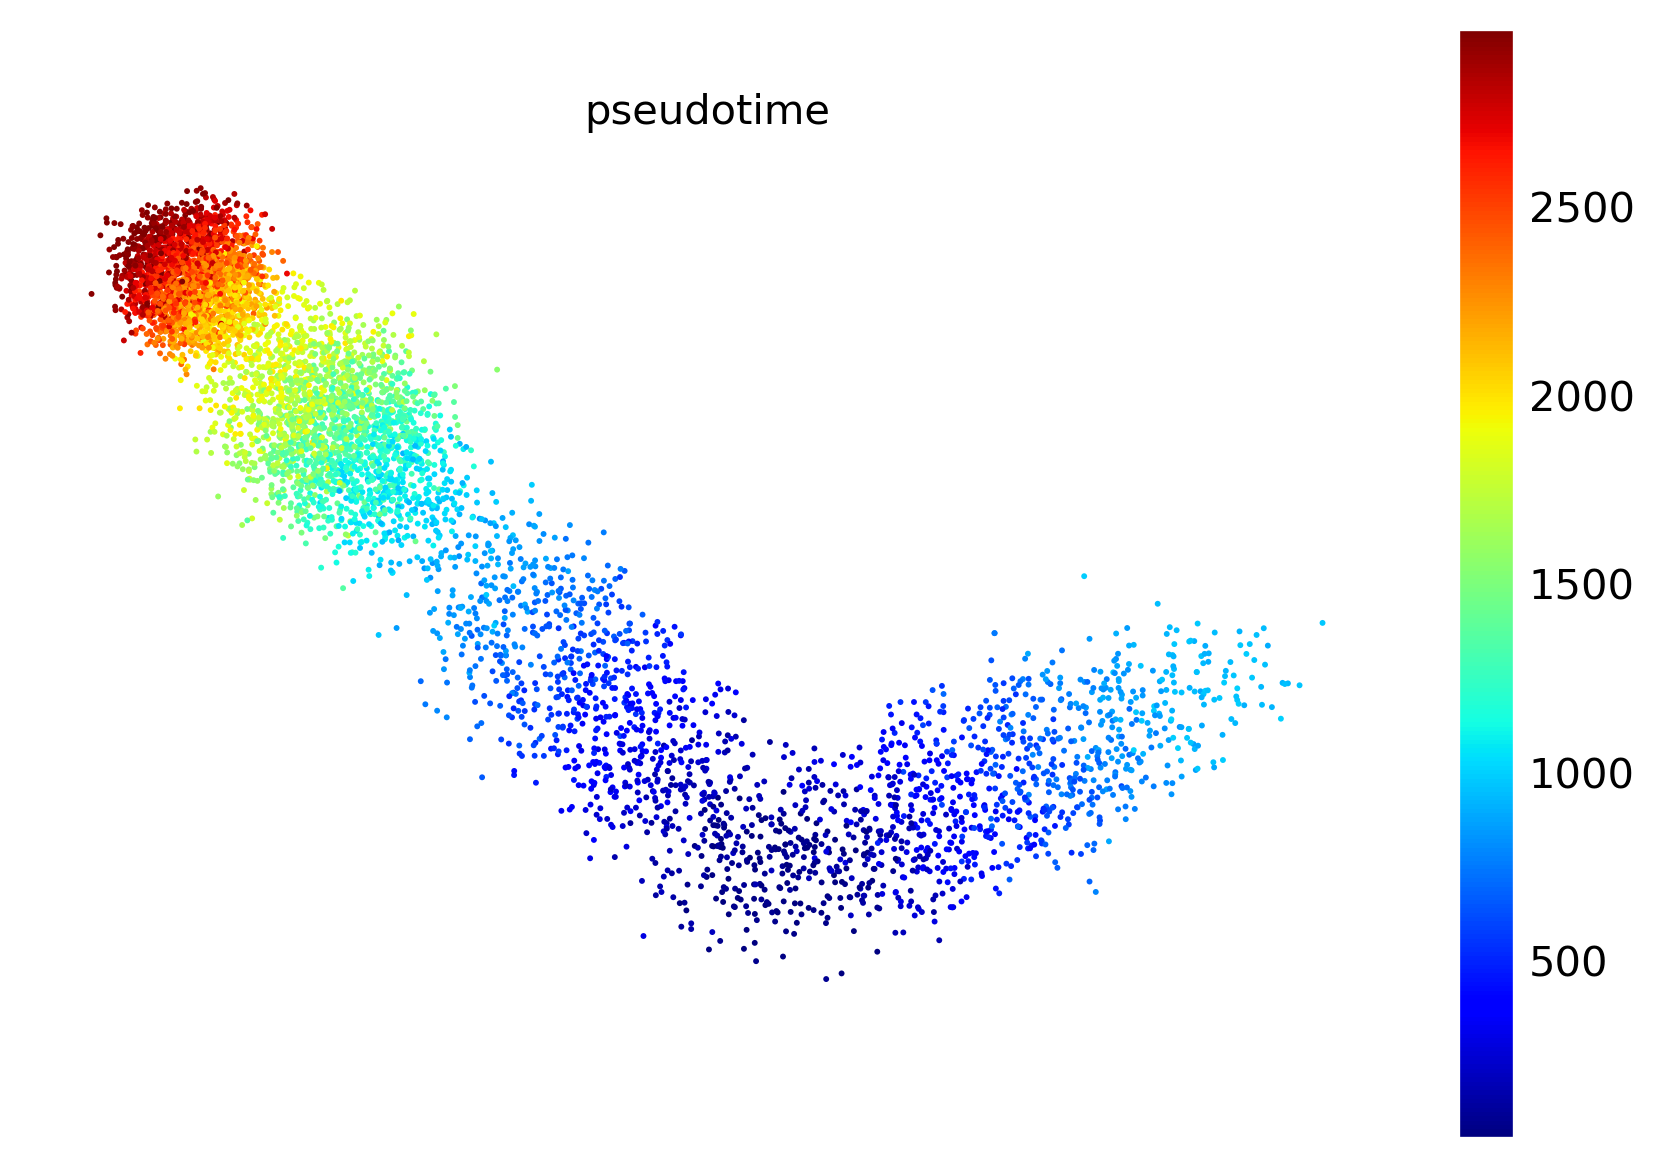

In [9]:
# Generate 3D plot
plot = oci.pl.scatter(adata, x_key='modality0', color_key='pseudotime', marker_size=3, method='plotly', axes_visible=True, cmap='jet')
plot.write_html(join(folder_path, 'Modality 0 pseudotime.html'))

# Generate 2D plot
oci.pl.scatter(adata, x_key='modality0_proj', color_key='pseudotime', marker_size=2, cmap='jet', fontsize=10)

The data structure present in one modality may be masked in anothers. ``modality1`` allows us to uncover lineages of types C and D, undistinguishable in ``modality0``.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

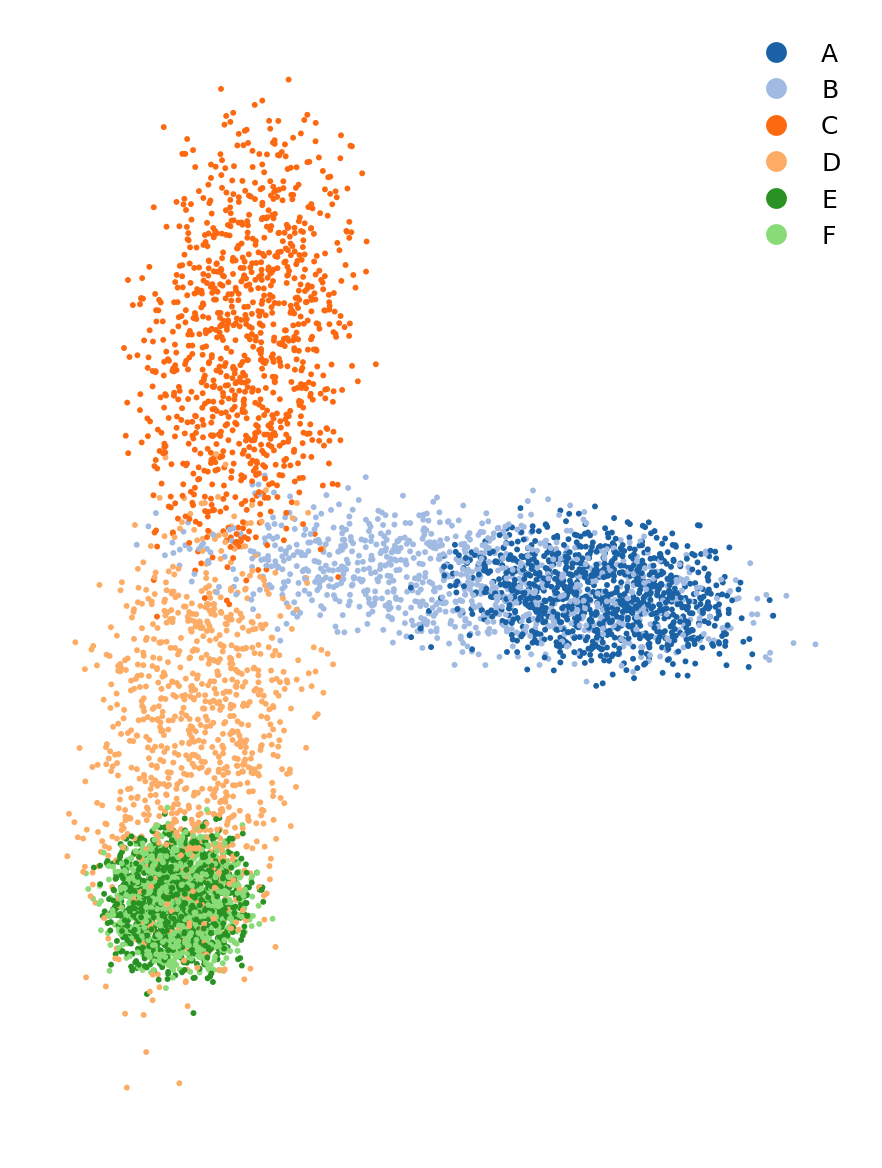

In [10]:
plot = oci.pl.scatter(adata, x_key='modality1', color_key='type', marker_size=3, method='plotly', axes_visible=True)
plot.write_html(join(folder_path, 'Modality 1 type.html'))

oci.tl.project_2d(adata, x_key='modality1', output_key='modality1_proj', alpha=90, beta=0)
oci.pl.scatter(adata, x_key='modality1_proj', color_key='type', marker_size=2, cmap=cmap)

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

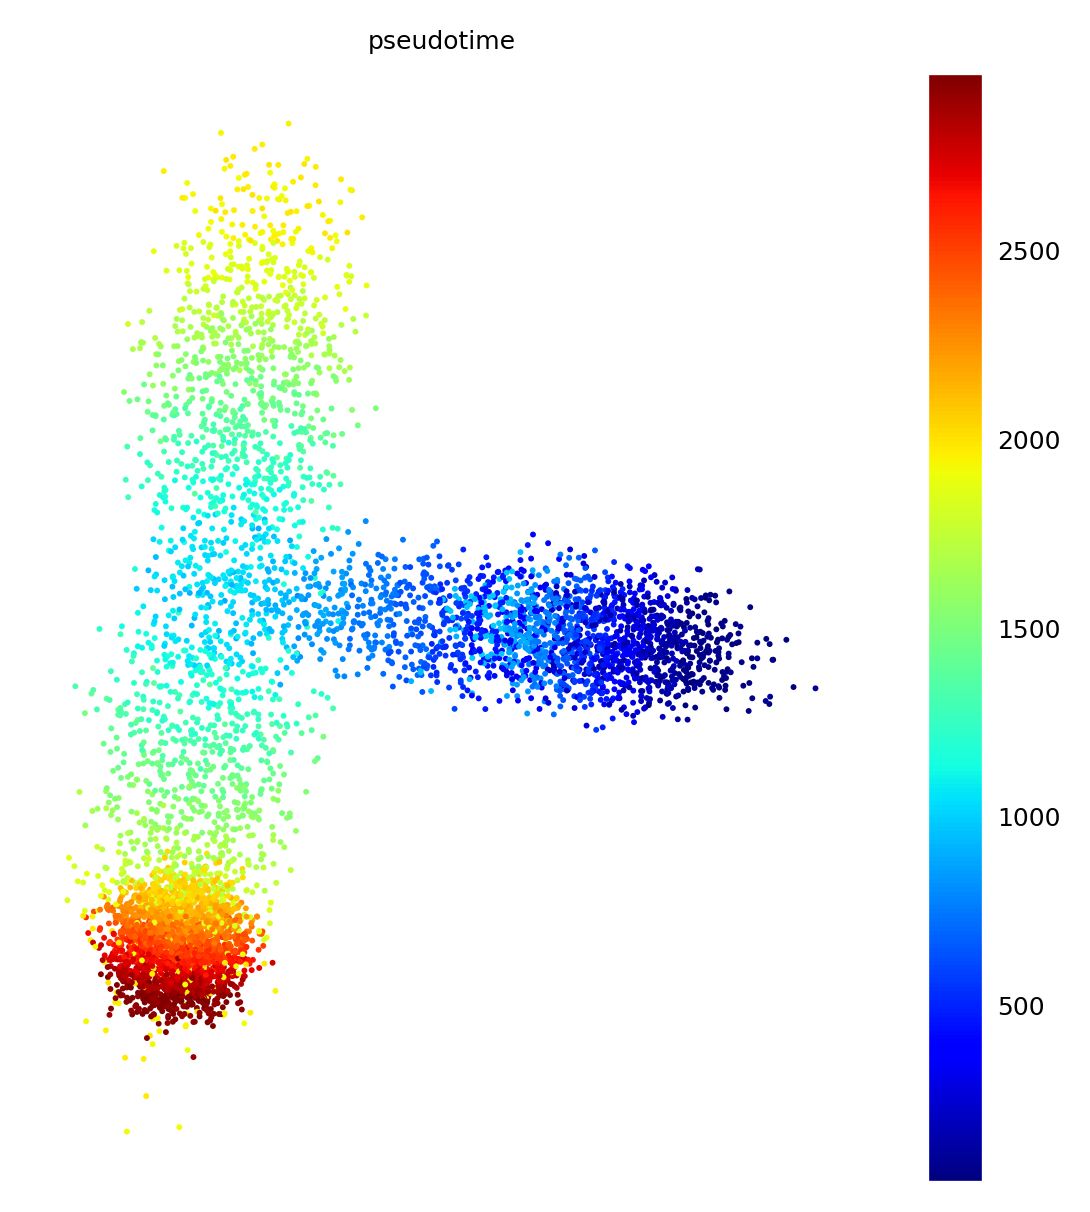

In [11]:
plot = oci.pl.scatter(adata, x_key='modality1', color_key='pseudotime', marker_size=3, method='plotly', axes_visible=True, cmap='jet')
plot.write_html(join(folder_path, 'Modality 1 pseudotime.html'))

oci.pl.scatter(adata, x_key='modality1_proj', color_key='pseudotime', marker_size=2, cmap='jet')

Similarly, ``modality2`` reveals that observations E and F are separate lineages, which is unseen when looking at ``modality0`` or ``modality1``.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

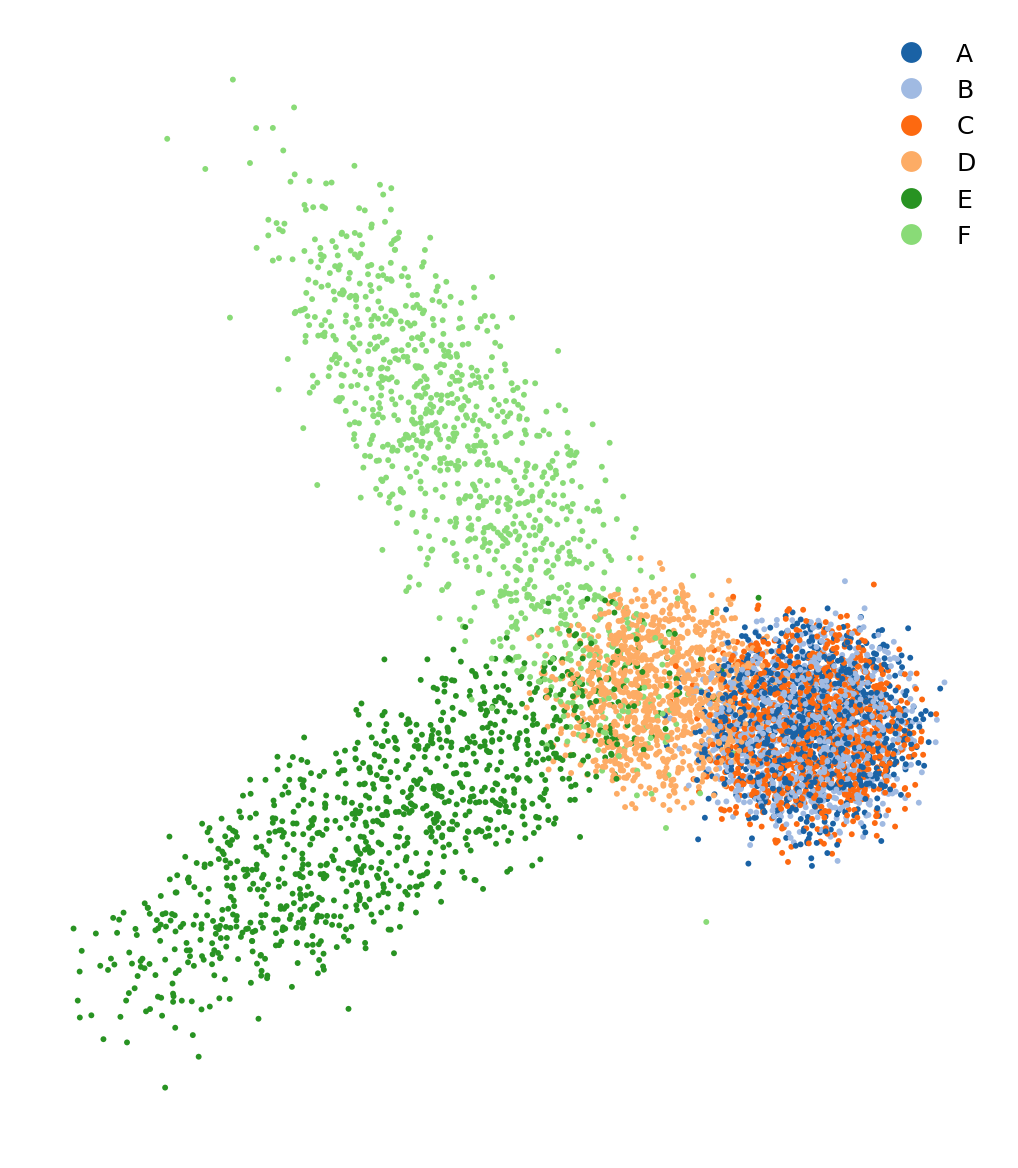

In [12]:
plot = oci.pl.scatter(adata, x_key='modality2', color_key='type', marker_size=3, method='plotly', axes_visible=True)
plot.write_html(join(folder_path, 'Modality 2 type.html'))

oci.tl.project_2d(adata, x_key='modality2', output_key='modality2_proj', alpha=0, beta=0)
oci.pl.scatter(adata, x_key='modality2_proj', color_key='type', marker_size=2, cmap=cmap)

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

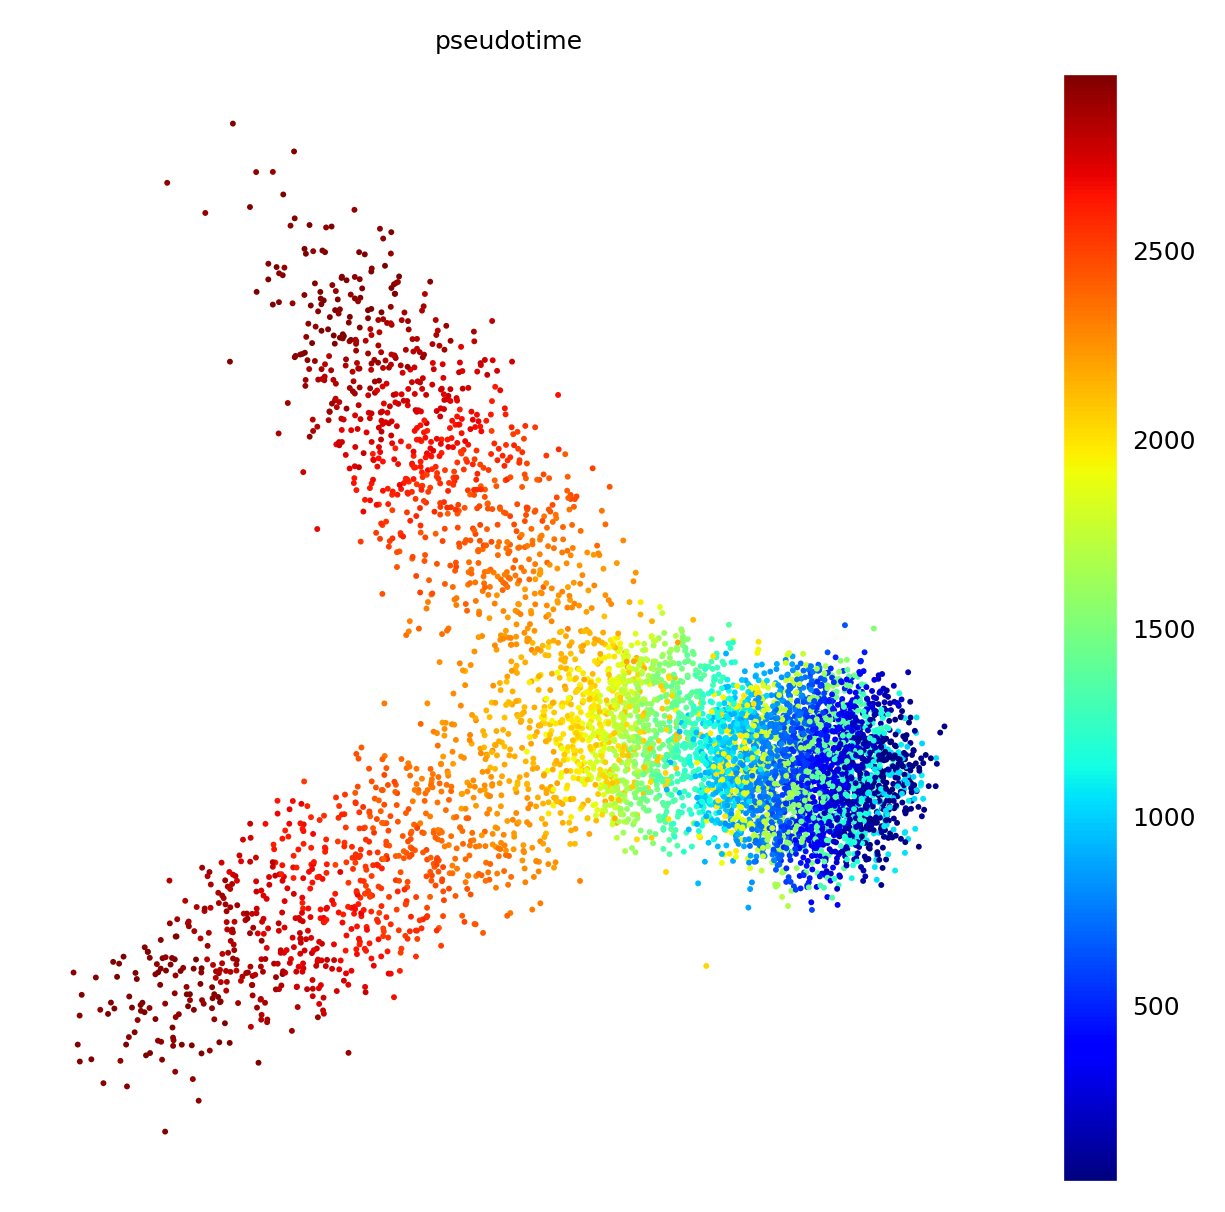

In [13]:
plot = oci.pl.scatter(adata, x_key='modality2', color_key='pseudotime', marker_size=3, method='plotly', axes_visible=True, cmap='jet')
plot.write_html(join(folder_path, 'Modality 2 pseudotime.html'))

oci.pl.scatter(adata, x_key='modality2_proj', color_key='pseudotime', marker_size=2, cmap='jet')

All the plots presented so far are unimodal - they don't visualize all levels of information. Ocelli provides tools for embedding multimodal data into a single, multimodal latent space using the Multimodal Diffusion Maps (MDM) algorithm. This process can be split into three stages:

- finding nearest neighbors in the feature space,
- calculation of multimodal weights for each observation,
- calculation of MDM embedding.

At this stage, it is important to specify two parameters. Larger values of ``n_neighbors`` make multimodal weights more global and less local. However, for all single-cell analyses, we recommend its value in 20-50 range. ``n_components`` defines the dimensionality of the MDM embedding. A good practice is to explore different values for each dataset individually. MDM components are information-rich, but their quality can degrade with quantity.

*Technical remark: We set parameter ``unimodal_norm``'s value to False only for simulated data. For single-cell data, we use its default True value. In other words, you can forget about ``unimodal_norm`` when working with single cells. ``unimodal_norm``'s value is changed here because the simulated 3D data is sampled from an artificial distribution, which is low-dimensional, dense, and not normalized. Single-cell data come from high-dimensional latent spaces of incomparable complexity that are properly normalized during data preprocessing (details in the following tutorials).*

In [14]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=10, unimodal_norm=False, verbose=True, random_state=SEED)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.


2022-11-25 23:36:11,086	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2022-11-25 23:36:16,367	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


The resulting 10-dimensional MDM embedding represents a multimodal latent space from which the modeled developmental process originates. The embedding is saved to ``adata.obsm['X_mdm']``. Below, we visualize it using ForceAtlas2, a force-directed layout algorithm for graph visualization, in three steps:

- finding nearest neighbors in the MDM latent space,
- computing the nearest neighbor graph,
- calculating the ForceAtlas2 graph representation.

In [15]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=30, verbose=True)
oci.tl.neighbors_graph(adata, n_edges=30, neighbors_key='X_mdm', verbose=True)
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED, output_key='X_fa2')

[X_mdm]	30 nearest neighbors calculated.
[X_mdm] Nearest neighbors-based graph constructed.


Nov 25, 2022 11:36:30 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Nov 25, 2022 11:36:31 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Nov 25, 2022 11:36:31 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (108,678 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 27.472s


The ForceAtlas2 representation is saved to ``adata.obsm['X_fa2']``. Thanks to MDM, all observation types A-F are now separated with well-defined branching points. It is easy to trace all developmental lineages, which were impossible to spot together in unimodal exploration.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

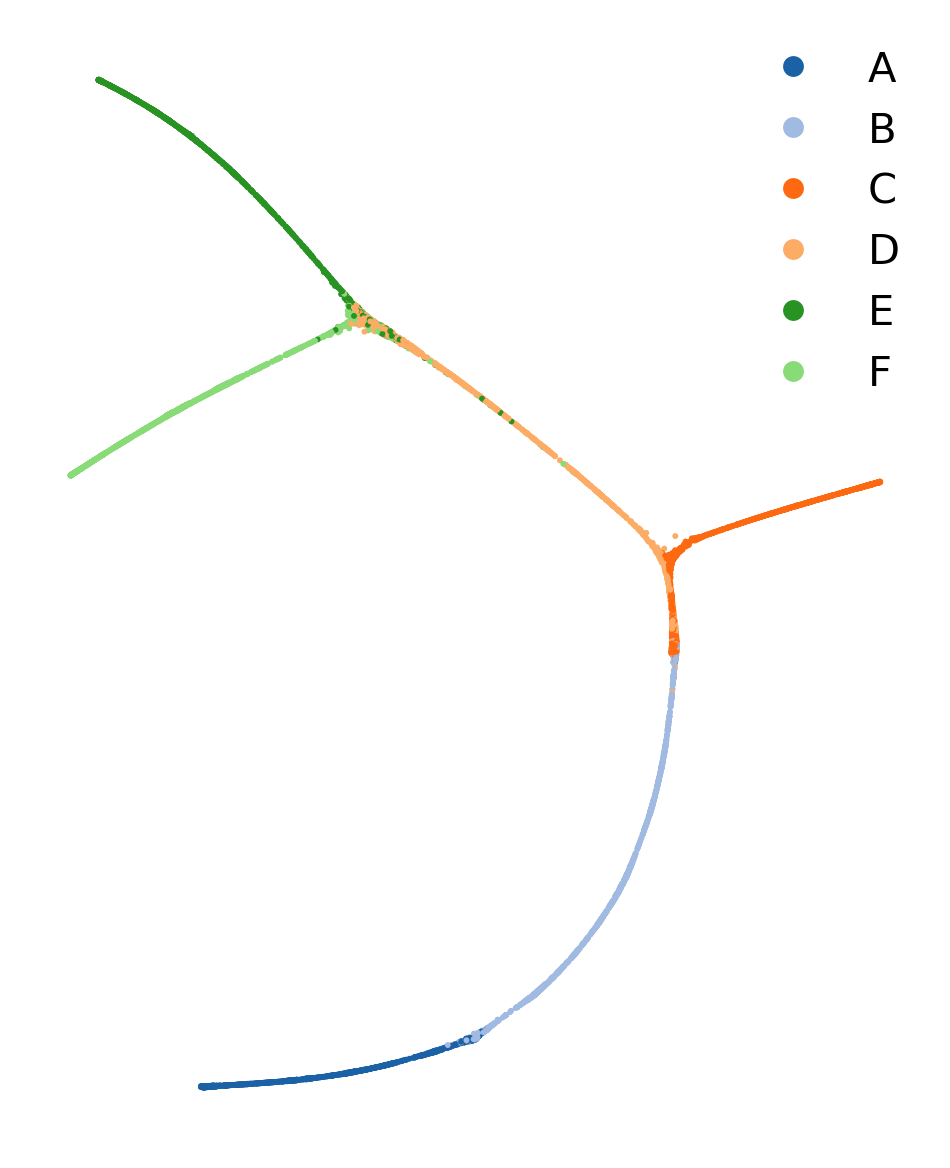

In [16]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='type', cmap=cmap, marker_size=2, fontsize=10)

Moreover, the ordering of cells is preserved from the modalities' feature spaces.

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

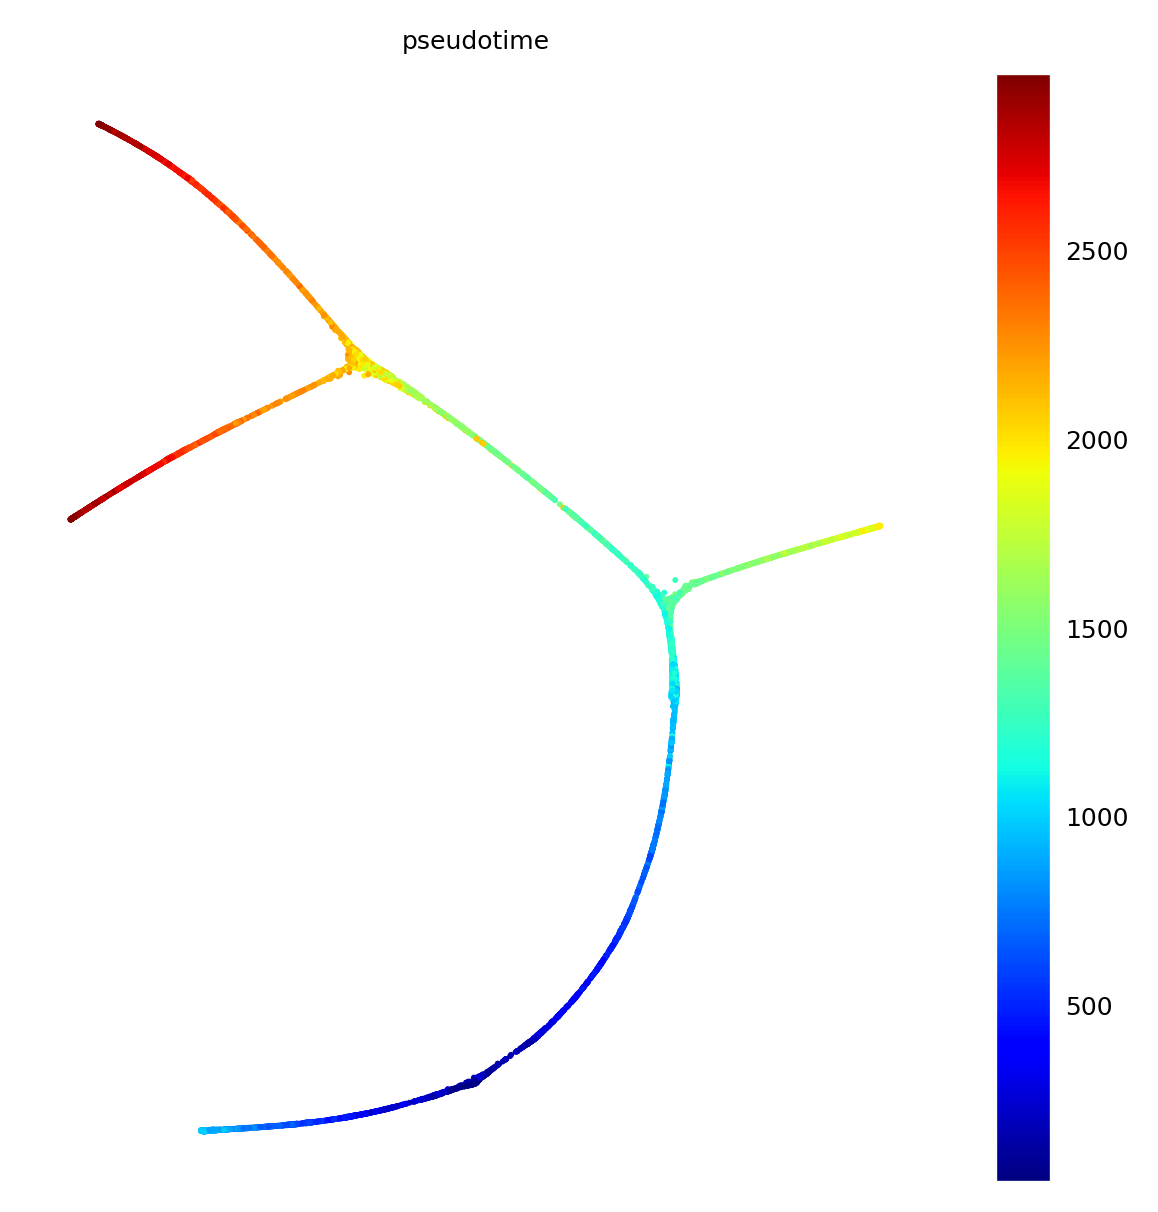

In [17]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='pseudotime', cmap='jet', marker_size=2)

Alternatively, you can use UMAP or any other dimension reduction algorithm to visualize the MDM embedding. Ocelli has built-in wrappers for ForceAtlas2 and UMAP. For well-connected data, we recommend ForceAtlas2, and for data with separate clusters, UMAP.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

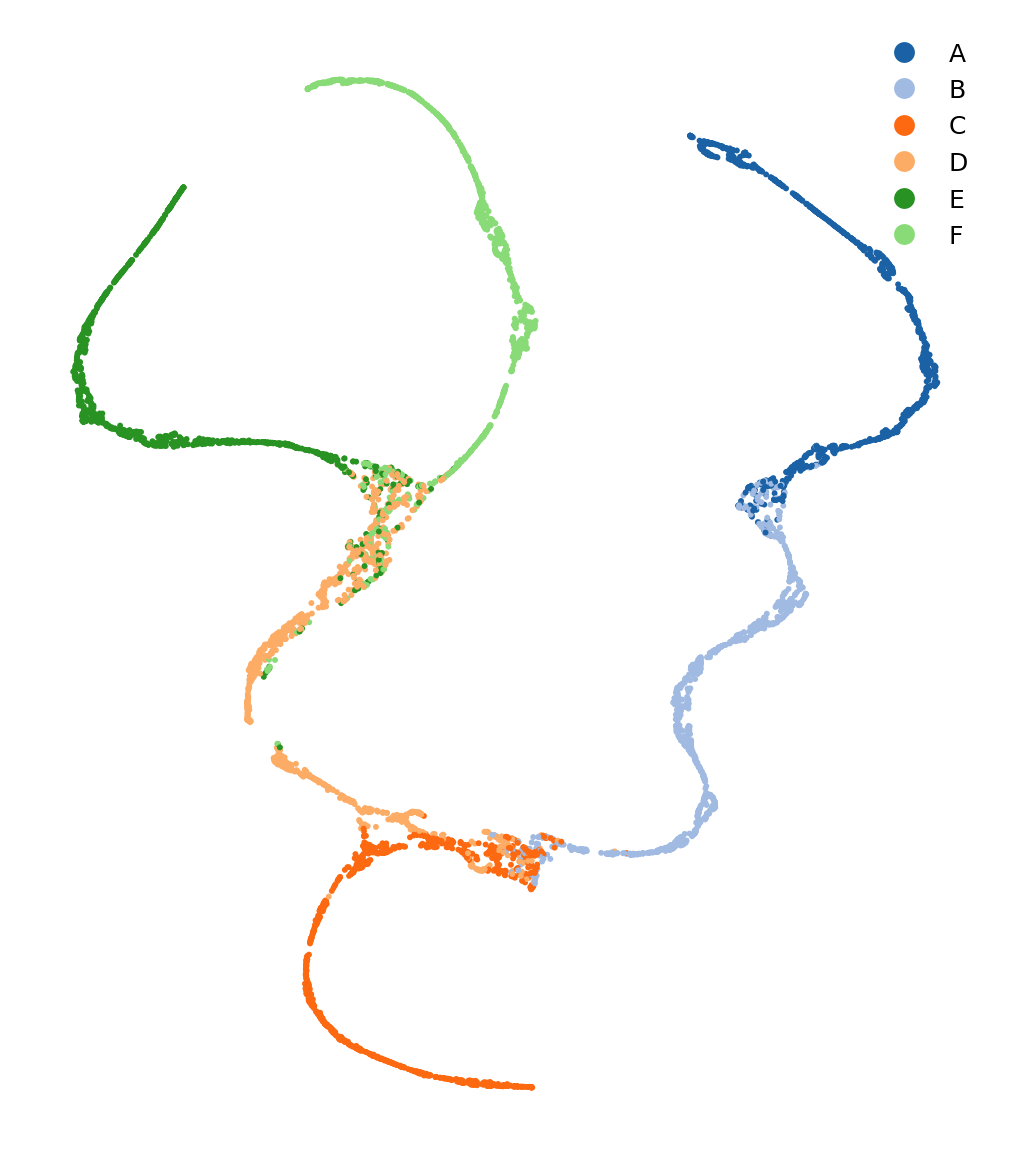

In [18]:
oci.tl.UMAP(adata, n_components=2, n_neighbors=20, min_dist=0.1, random_state=SEED, x_key='X_mdm', output_key='X_umap')

oci.pl.scatter(adata, x_key='X_umap', color_key='type', cmap=cmap, marker_size=2)

Calculated multimodal weights provide an explainable insight into the algorithm's training. For each cell, weights form a distribution over modalities (each observation's weights sum to 1). A higher weight indicates that the algorithm selected the modality as more *informative* about observation and its neighborhood than others.

Multimodal weights are saved to ``adata.obsm['weights']``.

In [19]:
adata.obsm['weights']

modality0  modality1  modality2
0      0.973592   0.025576   0.000832
1      0.989186   0.008797   0.002017
2      0.992478   0.006181   0.001341
3      0.967995   0.030422   0.001583
4      0.993608   0.004865   0.001527
...         ...        ...        ...
5995   0.000107   0.000101   0.999793
5996   0.000115   0.000101   0.999784
5997   0.000117   0.000101   0.999782
5998   0.000159   0.000095   0.999746
5999   0.000148   0.000108   0.999744

[6000 rows x 3 columns]

You can examine weight distribution with respect to each observation type.

(<Figure size 1920x1440 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='modality0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>],
        [<AxesSubplot:ylabel='modality1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='modality2'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

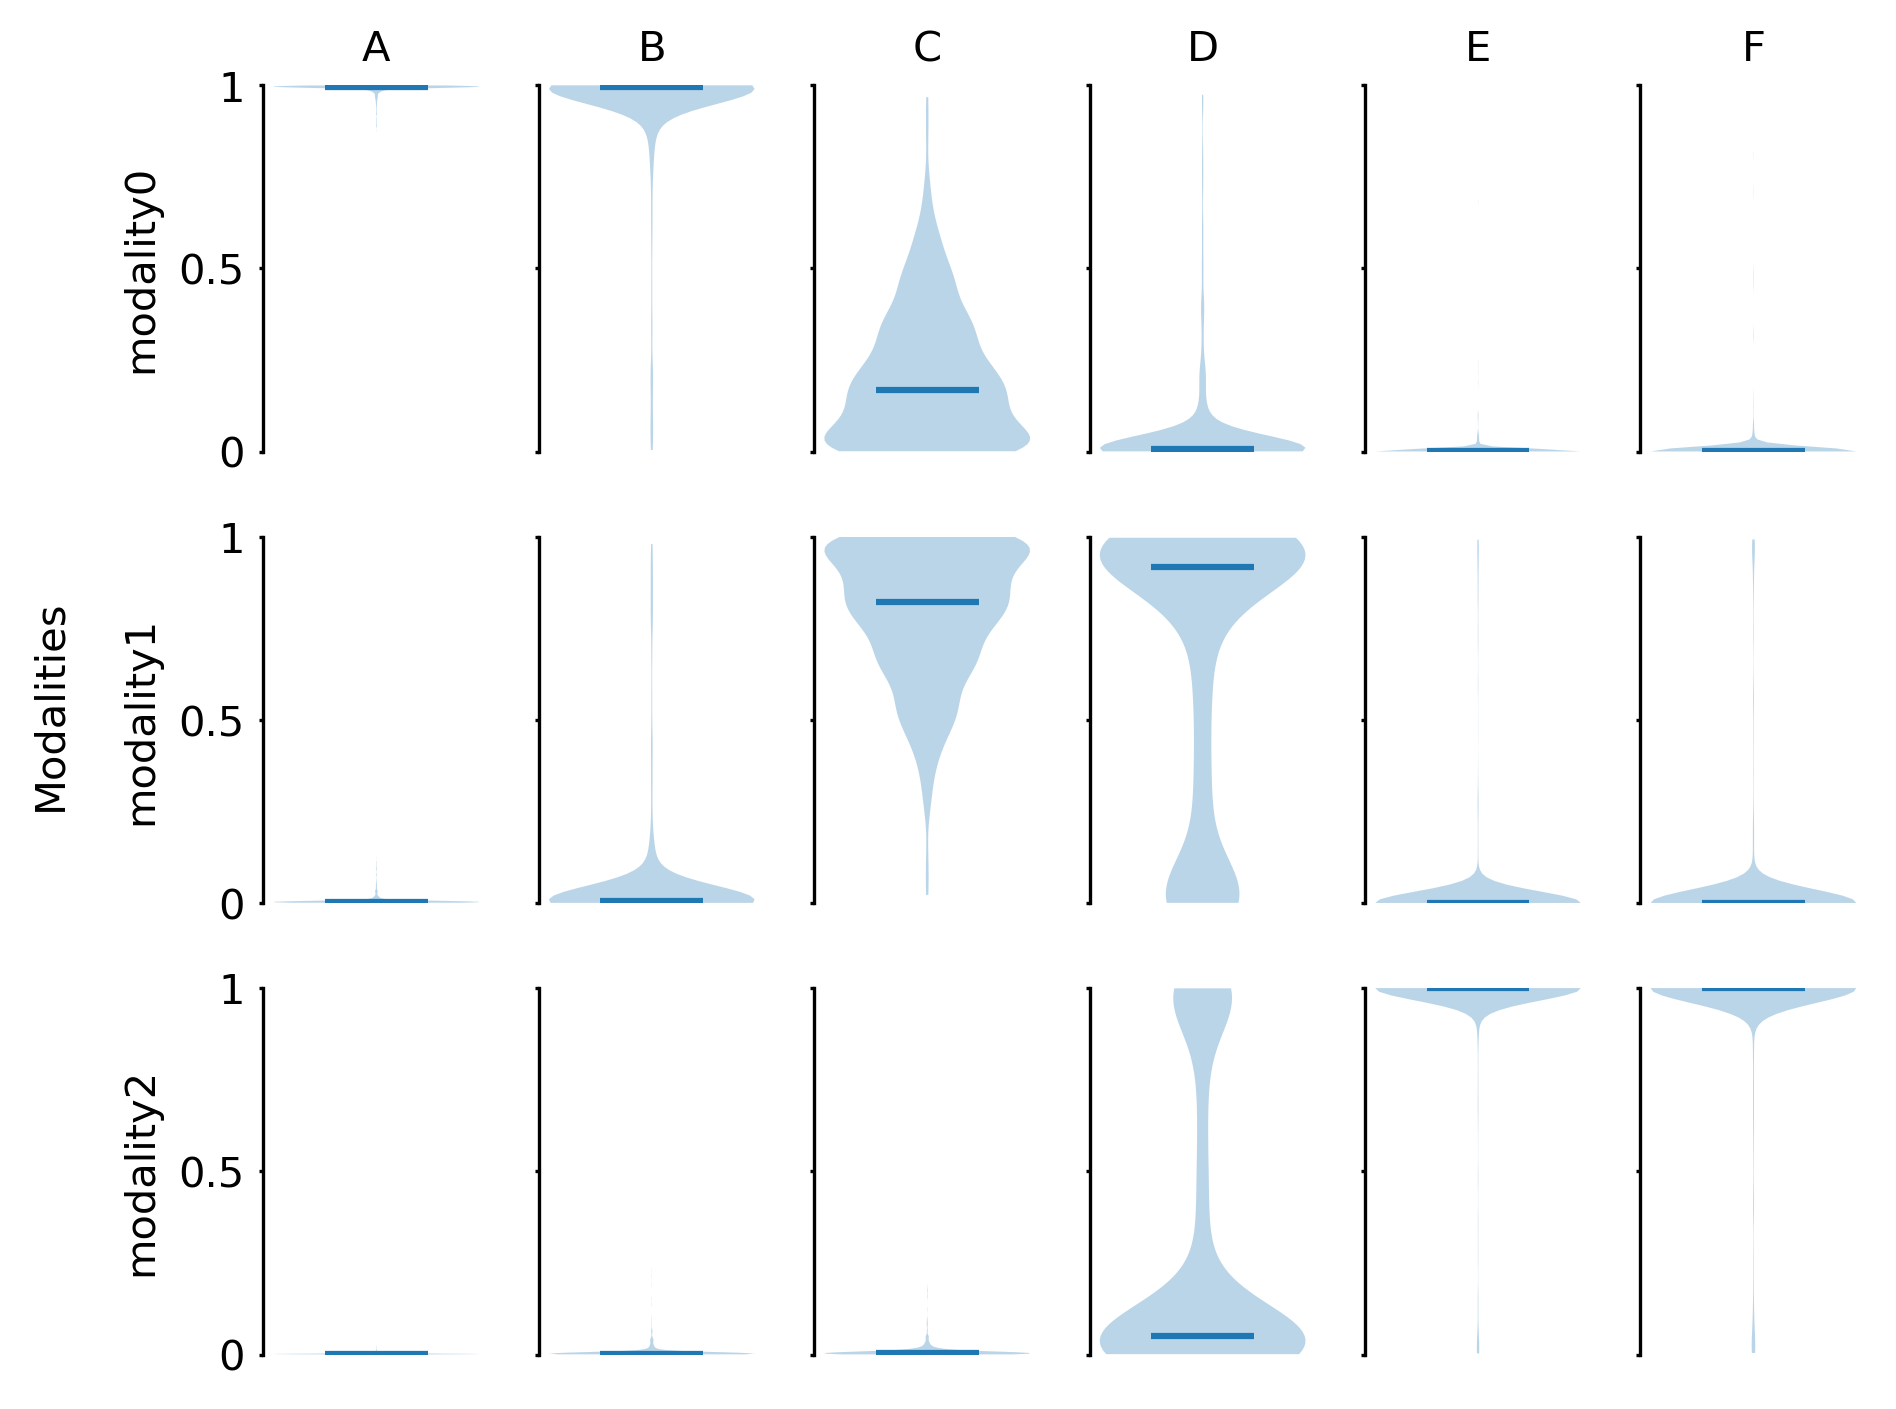

In [20]:
oci.pl.weights(adata, grouping_key='type', fontsize=10)

``modality0``'s weights are dominant for types A and B. ``modality1``'s weights are dominant for types C and D. ``modality2``'s weights are dominant for types E and F. You can further visualize multimodal weights on scatter plots.

(<Figure size 1920x1440 with 6 Axes>,
 array([<AxesSubplot:title={'center':'modality0'}>,
        <AxesSubplot:title={'center':'modality1'}>,
        <AxesSubplot:title={'center':'modality2'}>], dtype=object))

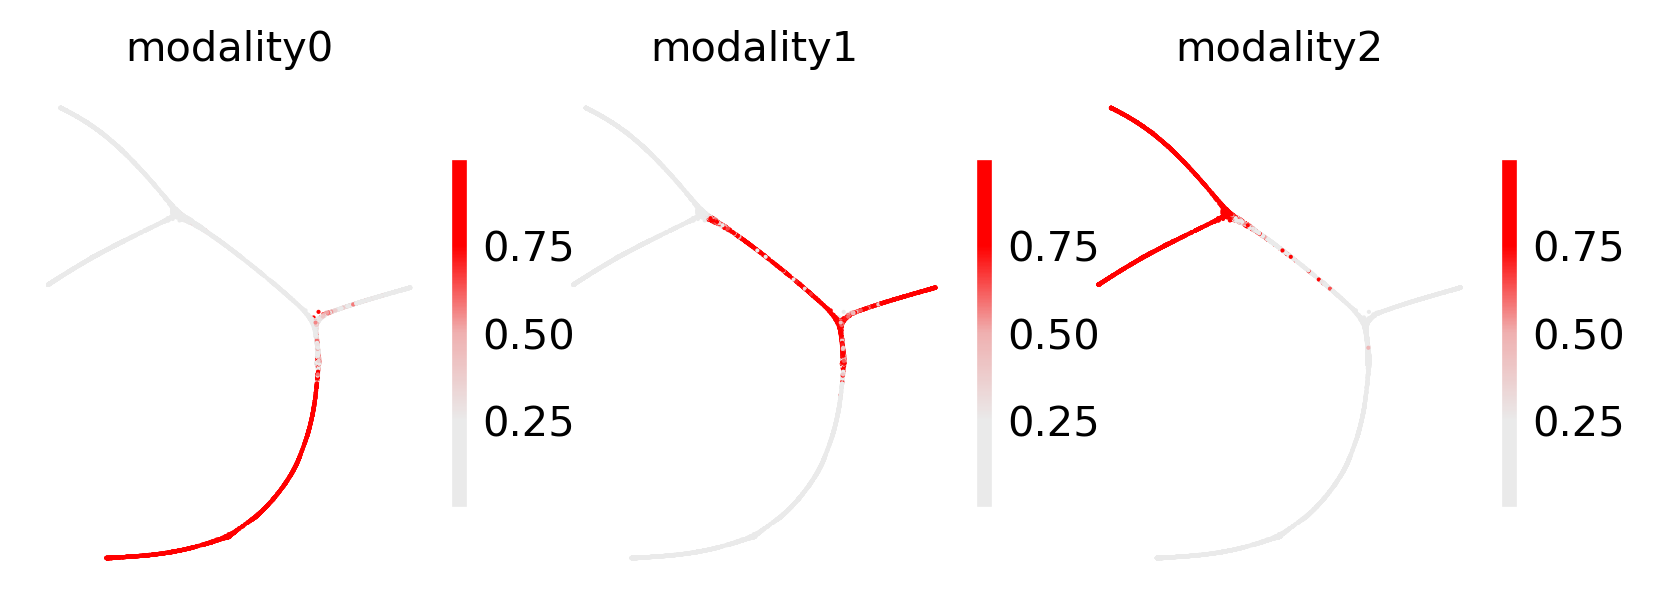

In [21]:
weights_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#EAEAEA', '#EAEAEA', '#EFB0B0', '#FF0000', '#FF0000'], N=256)

oci.pl.scatter(adata, x_key='X_fa2', color_key='weights', cmap=weights_cmap, marker_size=1, fontsize=10, legend=True)

Above, you investigated three modalities, each introducing a branching point starting two new lineages. Through multimodal analysis you managed to create a joint representation capturing all developmental fates, unseperable by single modalities. Now, let's further explore joint representations by limiting information feeded to MDM. Let's run MDM on just two modalities, e.g., only ``modality0`` and ``modality1``. This way, we take away information about ``modality2``'s branching point and the separability of type E and F fates.

Firstly, change ``adata.uns['modalities']`` so that MDM is trained on ``modality0`` and ``modality1``.

In [22]:
adata.uns['modalities'] = ['modality0', 'modality1']

Calculate multimodal weights and 10 MDM components.

In [23]:
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=10, unimodal_norm=False, verbose=True, random_state=SEED)

2022-11-25 23:37:37,413	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2022-11-25 23:37:42,611	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


Create the nearest neighbor graph in the MDM latent space and find its ForceAtlas2 representation.

In [24]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=30, verbose=True)
oci.tl.neighbors_graph(adata, n_edges=30, neighbors_key='X_mdm', verbose=True)
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED, output_key='X_fa2')

[X_mdm]	30 nearest neighbors calculated.
[X_mdm] Nearest neighbors-based graph constructed.


Nov 25, 2022 11:37:54 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Nov 25, 2022 11:37:54 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Nov 25, 2022 11:37:54 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (107,431 added)


*************************25%
*************************50%
*************************75%
********************

*****100%
Time = 31.214s


(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

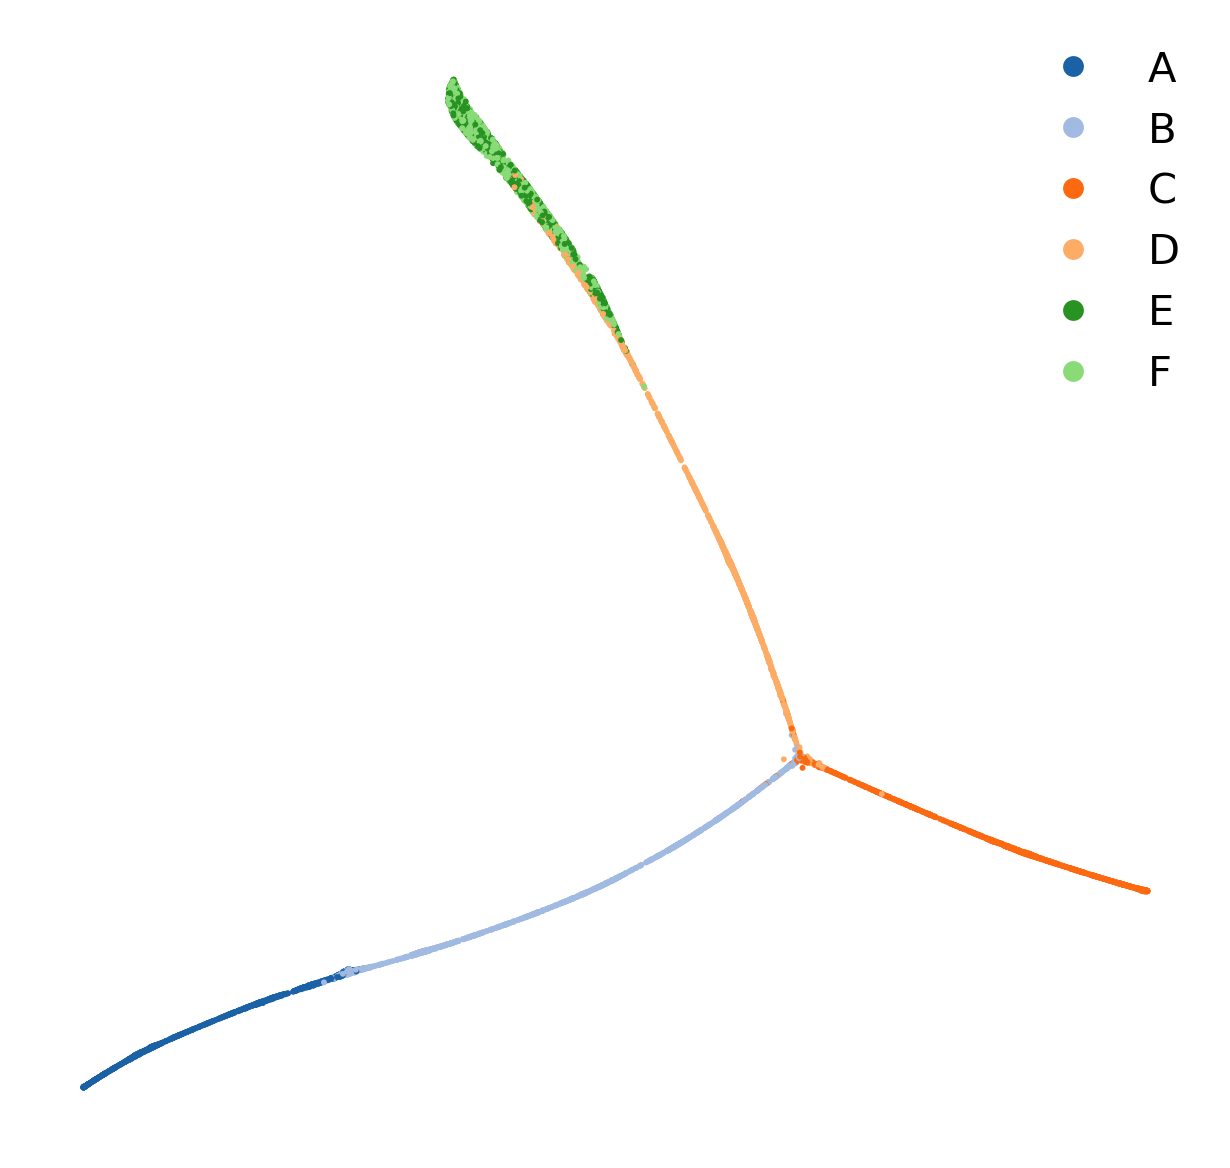

In [25]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='type', cmap=cmap, marker_size=2, fontsize=10)

As expected, developmental fates E and F from unused ``modality2`` are mixed, while lineages well-separated in ``modality0`` and ``modality1`` ale correctly reconstructed. Multimodal weights distribution shows why this happens.

(<Figure size 1920x1440 with 4 Axes>,
 array([<AxesSubplot:title={'center':'modality0'}>,
        <AxesSubplot:title={'center':'modality1'}>], dtype=object))

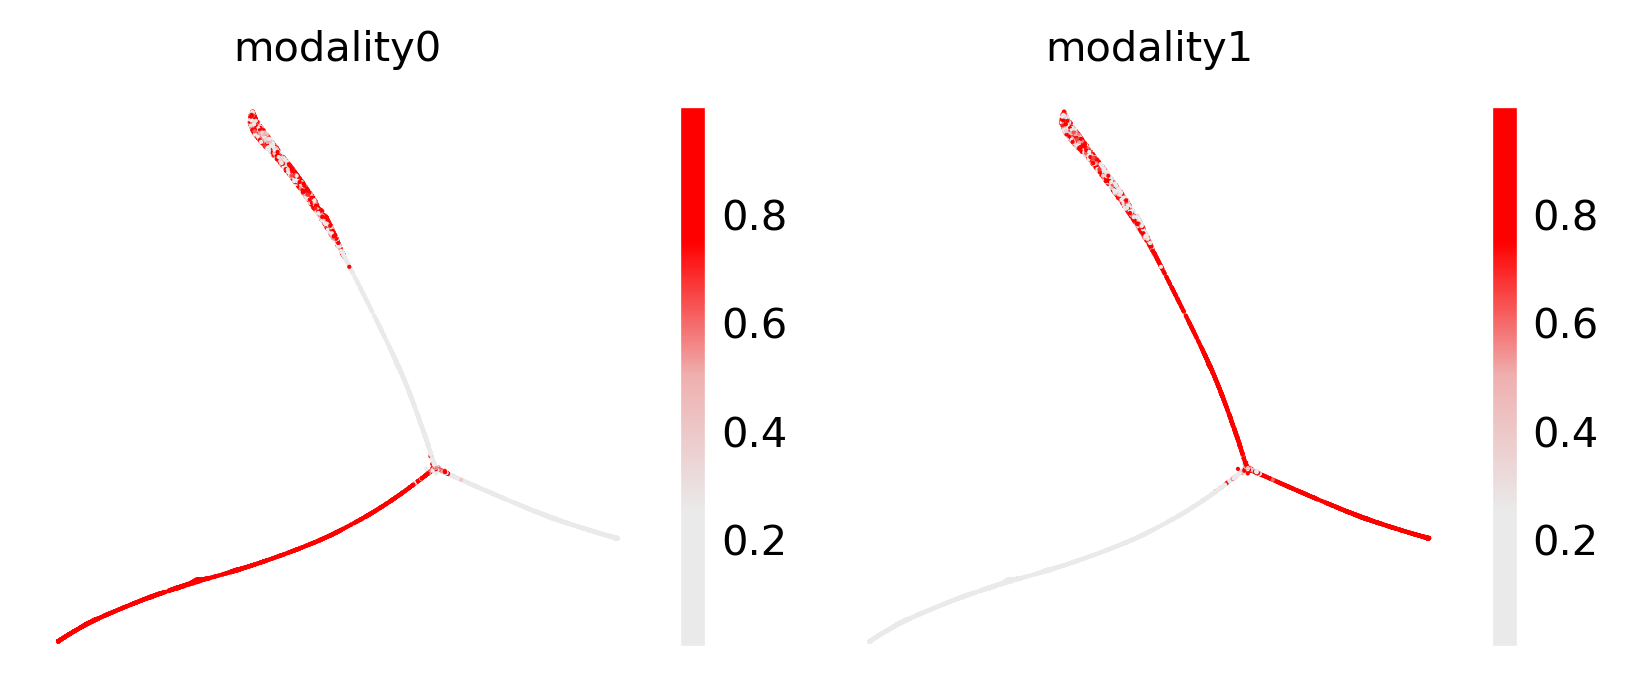

In [26]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='weights', cmap=weights_cmap, marker_size=1, fontsize=10)

(<Figure size 1920x1440 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='modality0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>],
        [<AxesSubplot:ylabel='modality1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

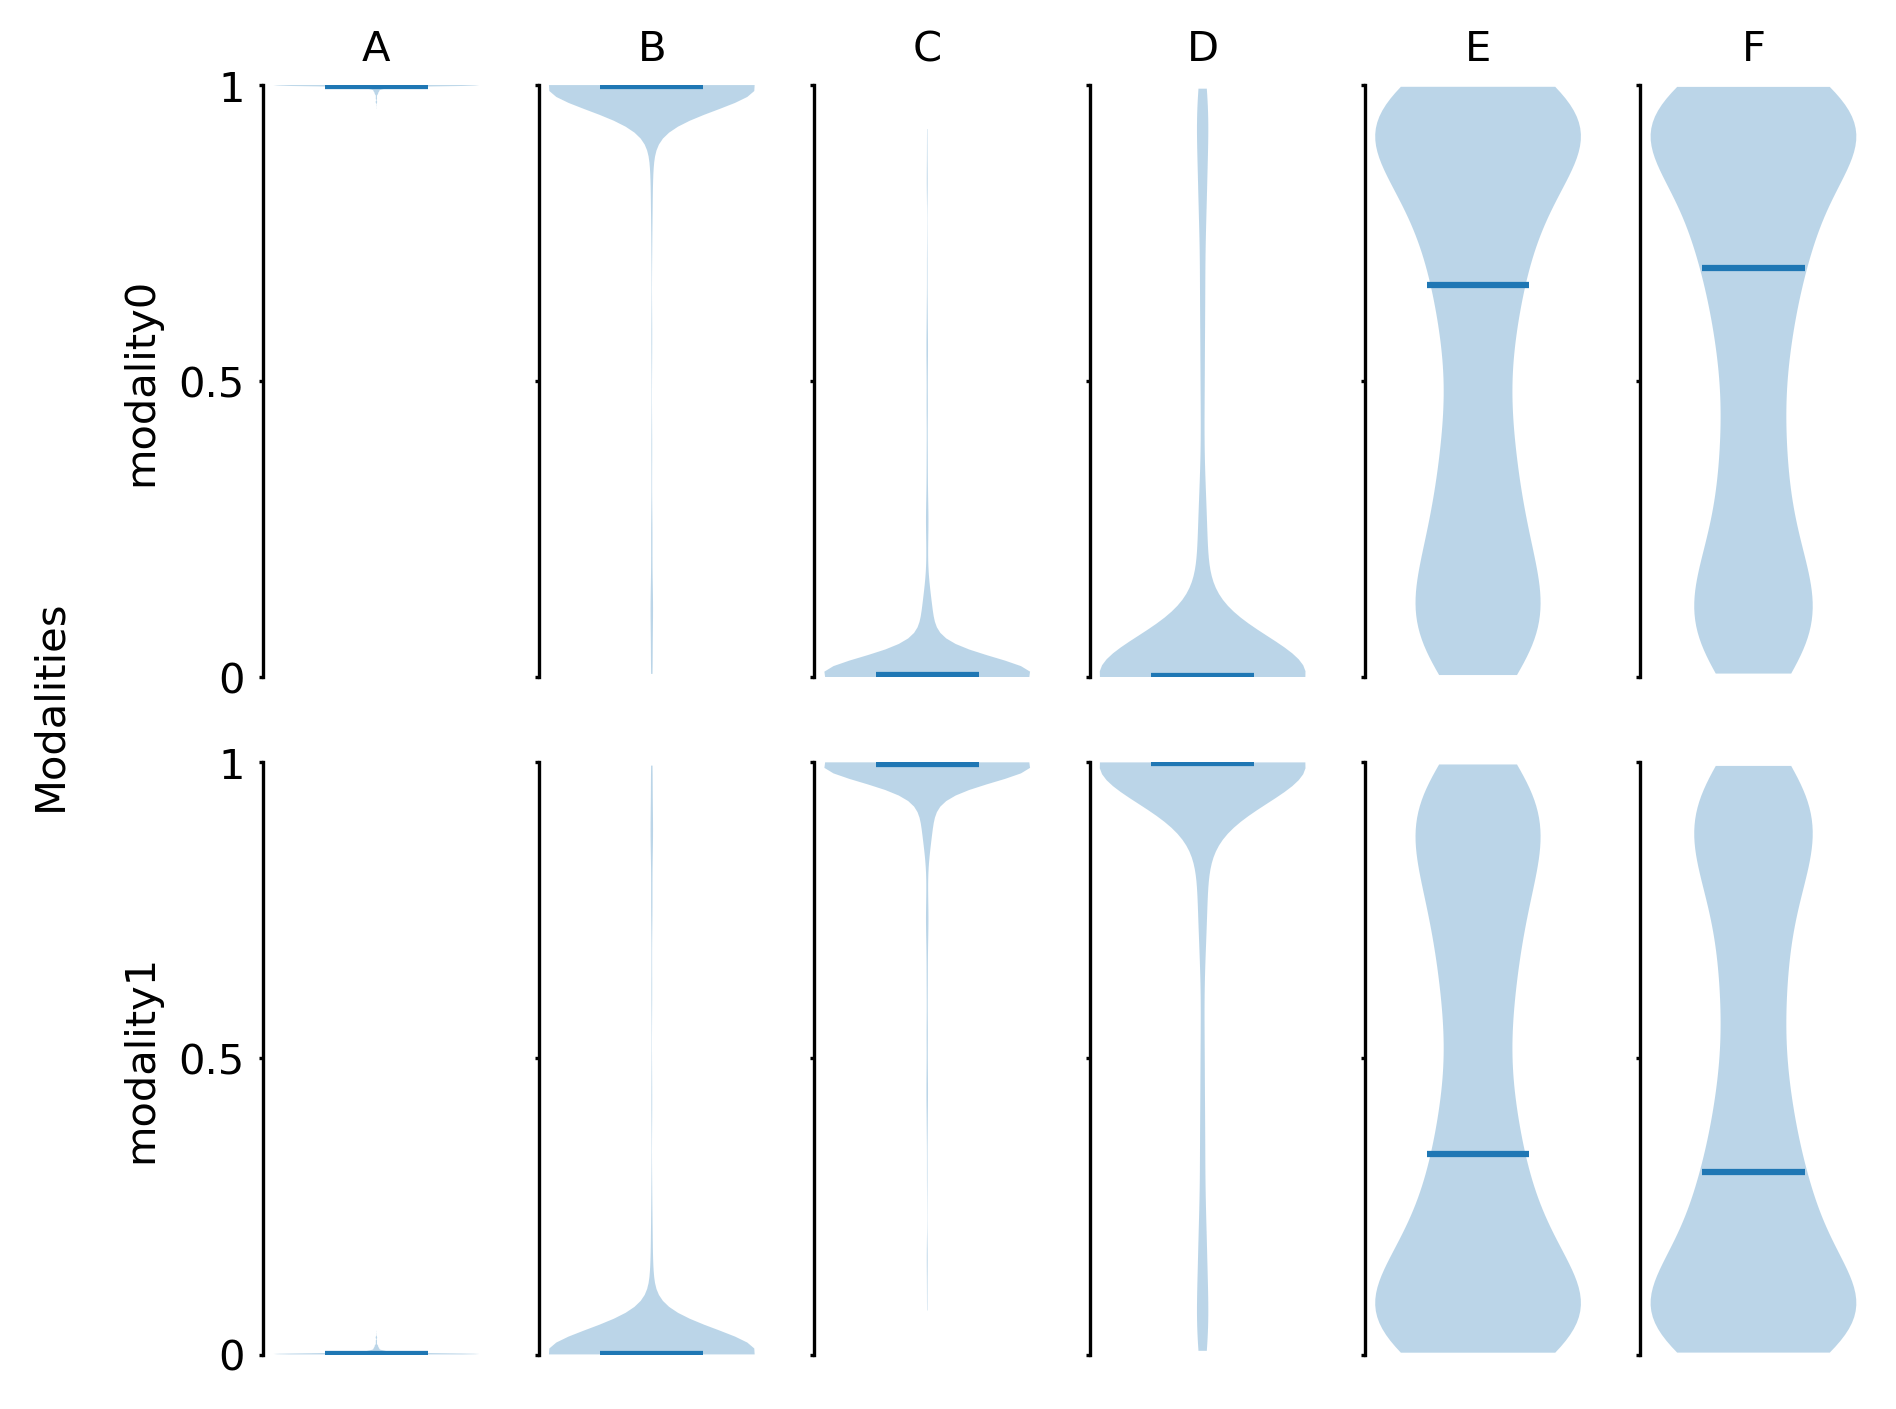

In [27]:
oci.pl.weights(adata, grouping_key='type', fontsize=10)

## Simulated data II

Here, we explore a developmental simulated dataset constaining 4500 observations and two modalities.

In [28]:
# a path to the folder with data
folder_path = '../../../data/simulated_data_ii'

adata = anndata.read_h5ad(join(folder_path, 'sparse-transitions-dataset.h5ad'))
adata

AnnData object with n_obs × n_vars = 4500 × 1
    obs: 'type', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1'

Observations are labeled into nine categories. ``modality0`` exposes types A-C as sparse transitions, but is unable to distinguish between fates D-I.

Note: 3D plots generated below are available for download [here](https://github.com/TabakaLab/ocelli/tree/dev/html/simulated_data_ii).

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

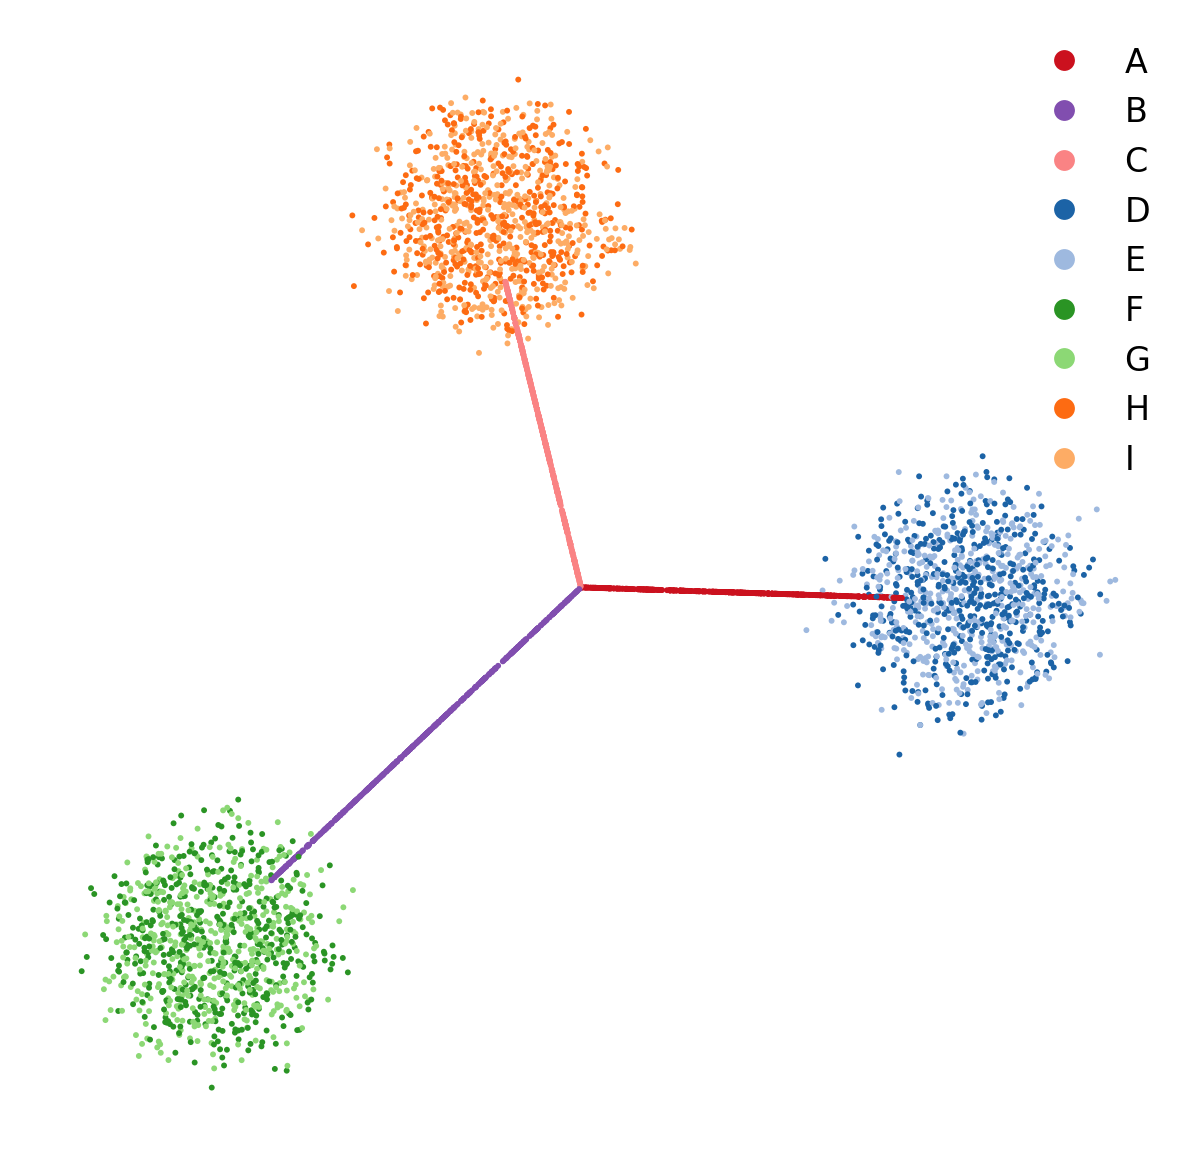

In [29]:
plot = oci.pl.scatter(adata, x_key='modality0', color_key='type', marker_size=3, method='plotly', axes_visible=True)
plot.write_html(join(folder_path, 'Modality 0 type.html'))

cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#cb111e', '#814eaf', '#fc8384', '#1a62a5', '#a0bae2', '#289322', '#89db77', '#fd6910', '#fdac65'], N=256)
oci.tl.project_2d(adata, x_key='modality0', output_key='modality0_proj', alpha=45, beta=45)
oci.pl.scatter(adata, x_key='modality0_proj', color_key='type', marker_size=2, cmap=cmap, fontsize=8, legend=True)

The developmental process is defined as follows.

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

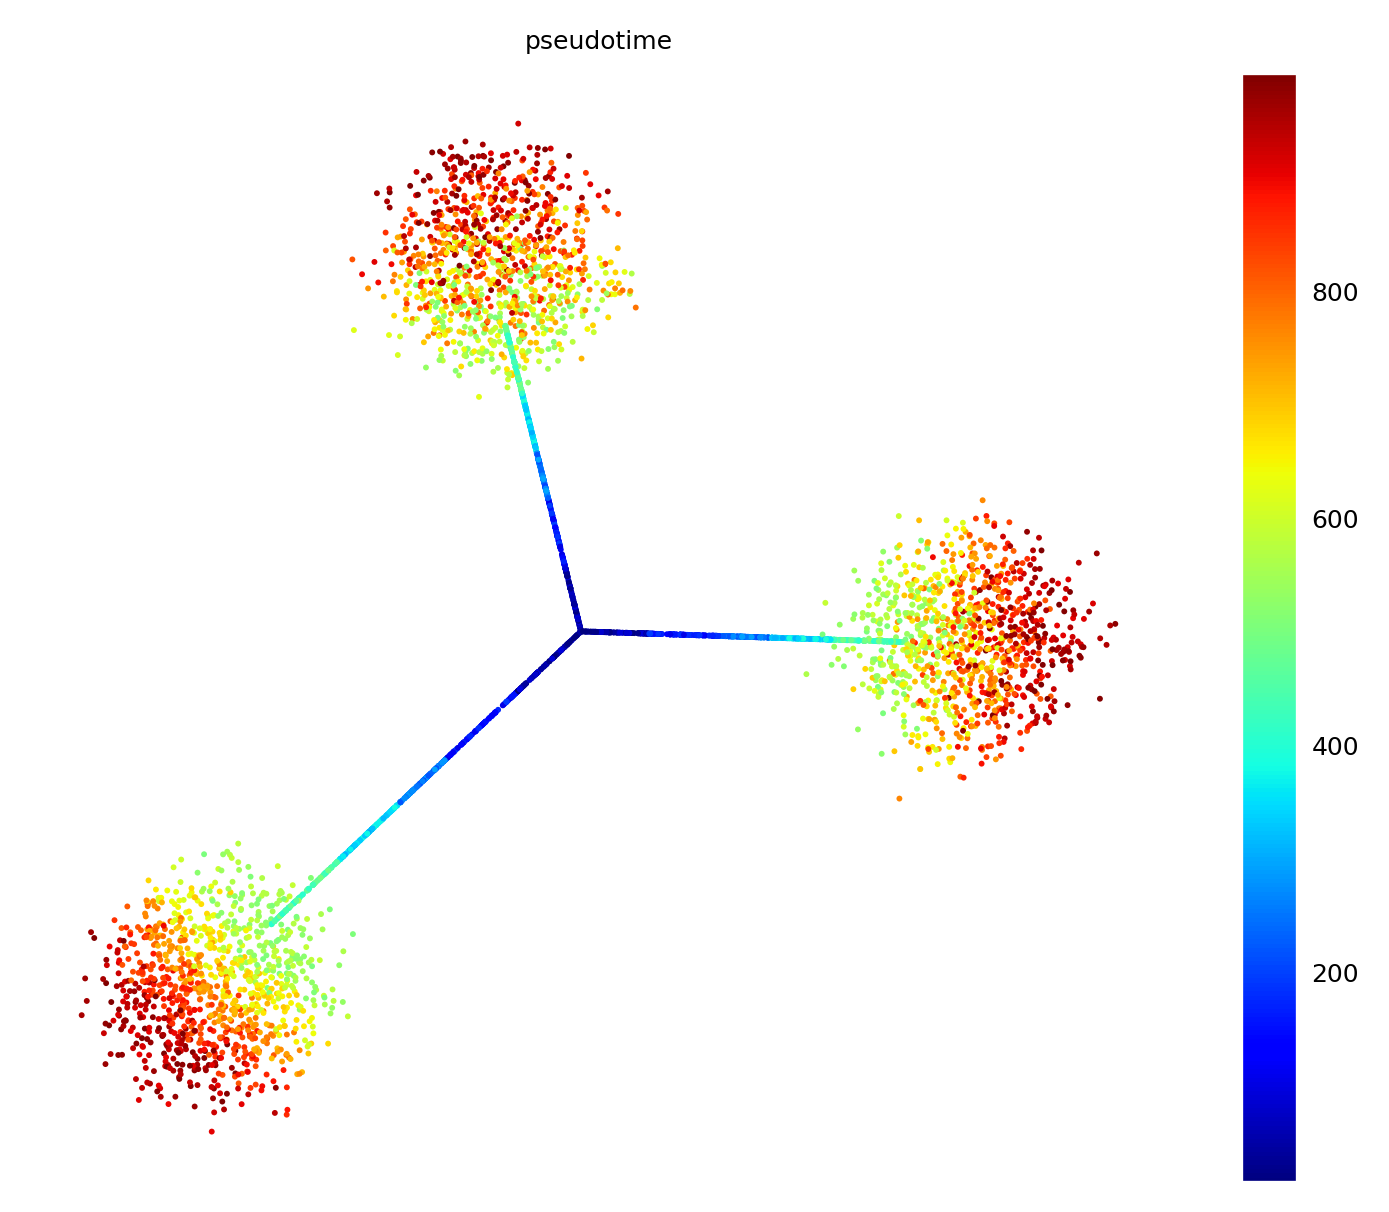

In [30]:
plot = oci.pl.scatter(adata, x_key='modality0', color_key='pseudotime', marker_size=3, method='plotly', axes_visible=True, cmap='jet')
plot.write_html(join(folder_path, 'Modality 0 pseudotime.html'))

oci.pl.scatter(adata, x_key='modality0_proj', color_key='pseudotime', marker_size=2, cmap='jet')

``modality1`` separates six developmental fates D-I, however, their origin (observations A-C) is ambiguous.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

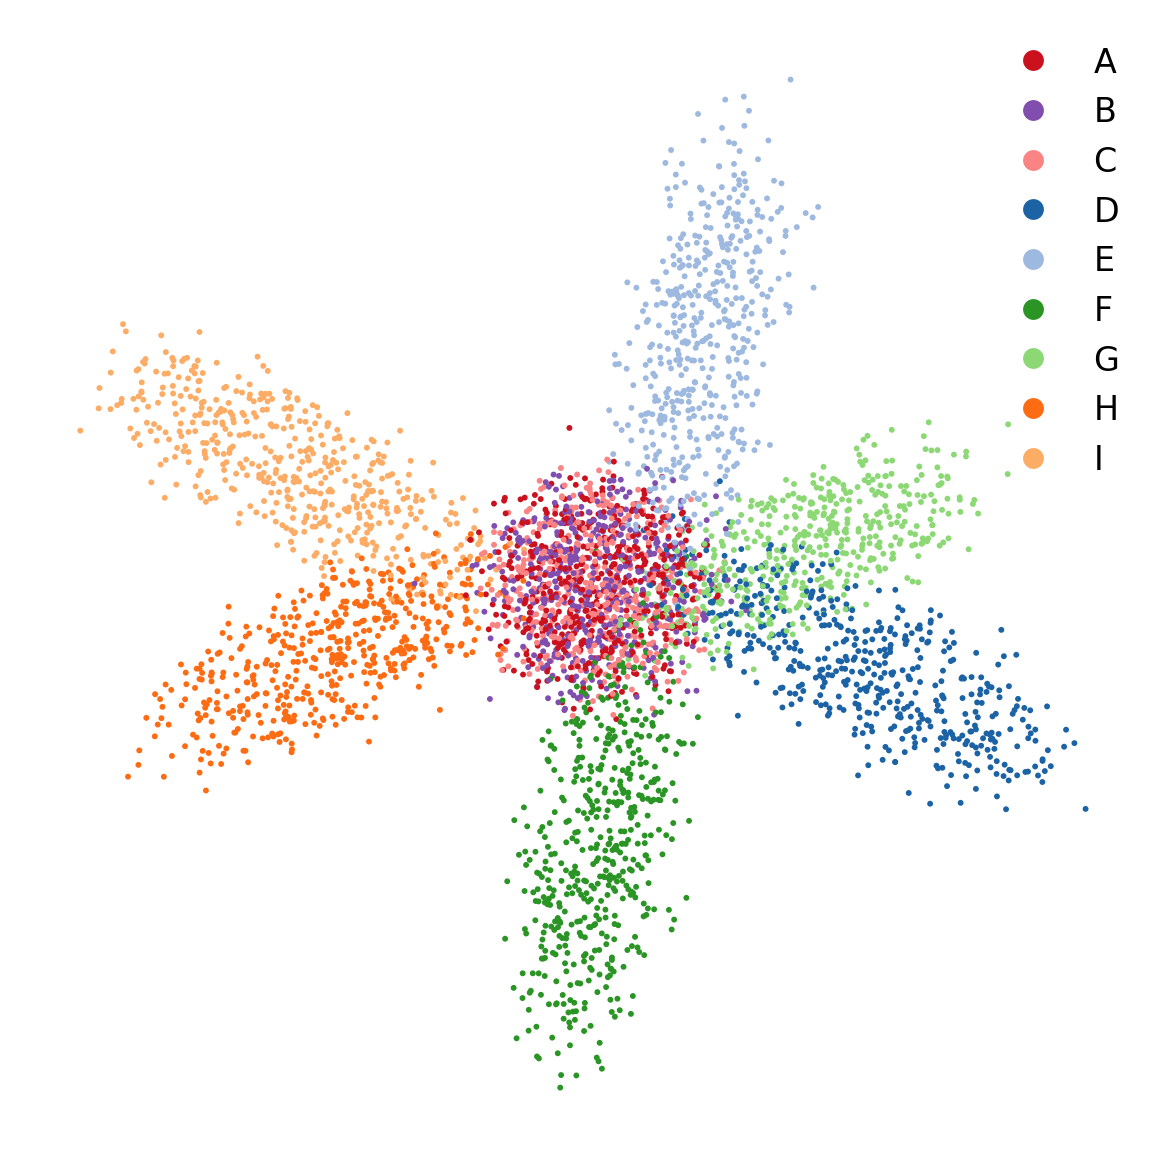

In [31]:
plot = oci.pl.scatter(adata, x_key='modality1', color_key='type', marker_size=3, method='plotly', axes_visible=True)
plot.write_html(join(folder_path, 'Modality 1 type.html'))

oci.tl.project_2d(adata, x_key='modality1', output_key='modality1_proj', alpha=45, beta=45)
oci.pl.scatter(adata, x_key='modality1_proj', color_key='type', marker_size=2, cmap=cmap, fontsize=8)

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

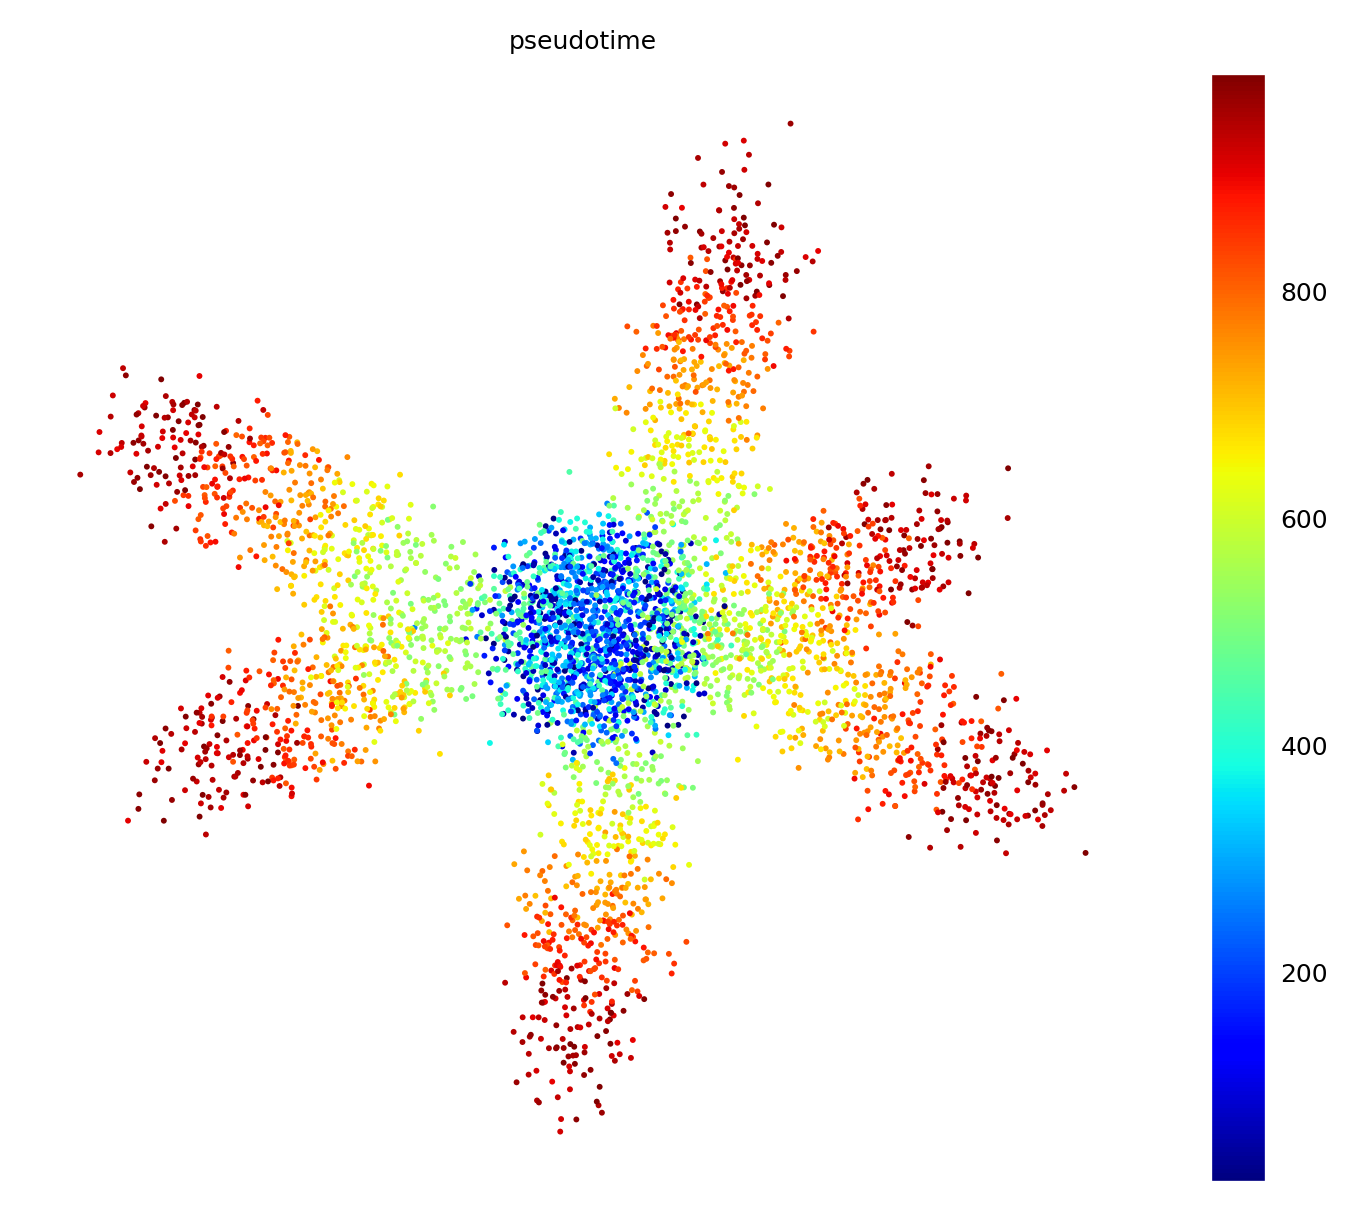

In [32]:
plot = oci.pl.scatter(adata, x_key='modality1', color_key='pseudotime', marker_size=3, method='plotly', axes_visible=True, cmap='jet')
plot.write_html(join(folder_path, 'Modality 1 pseudotime.html'))

oci.pl.scatter(adata, x_key='modality1_proj', color_key='pseudotime', marker_size=2, cmap='jet')

Let's proceed to the MDM analysis. First, calculate nearest neighbors, then multimodal weights and MDM components.

In [33]:
oci.pp.neighbors(adata, n_neighbors=60, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=20, unimodal_norm=False, verbose=True, random_state=SEED)

[modality0]	60 nearest neighbors calculated.
[modality1]	60 nearest neighbors calculated.


2022-11-25 23:38:30,441	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2022-11-25 23:38:35,816	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


Produce a ForceAtlas2 representation based on the nearest neighbors graph.

In [34]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=60, verbose=True)
oci.tl.neighbors_graph(adata, n_edges=60, neighbors_key='X_mdm', verbose=True)
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED, output_key='X_fa2')

[X_mdm]	60 nearest neighbors calculated.
[X_mdm] Nearest neighbors-based graph constructed.


Nov 25, 2022 11:38:49 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Nov 25, 2022 11:38:49 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 4,500 (4,500 added)
Nov 25, 2022 11:38:49 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 270,000 (152,392 added)


*************************25%
*************************50%
*************************75%
**********

***************100%
Time = 34.166s


MDM managed to fully reconstruct developmental fates D-I and their origin A-C.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

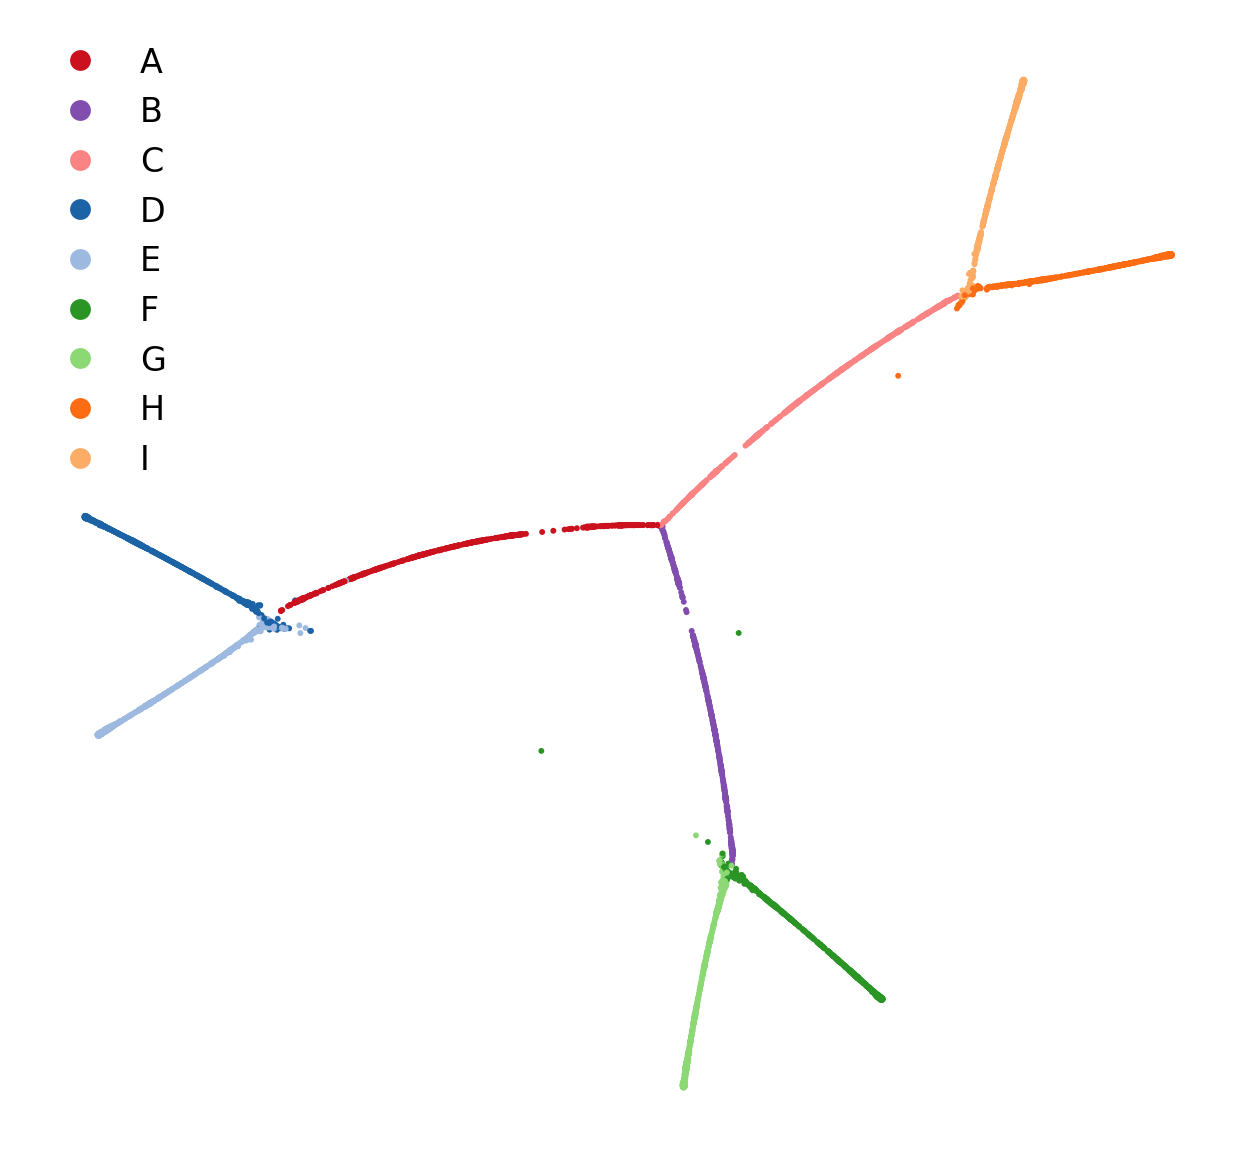

In [35]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='type', cmap=cmap, marker_size=2, fontsize=8)

Additionally, computed representation preserves the cell ordering.

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'pseudotime'}>)

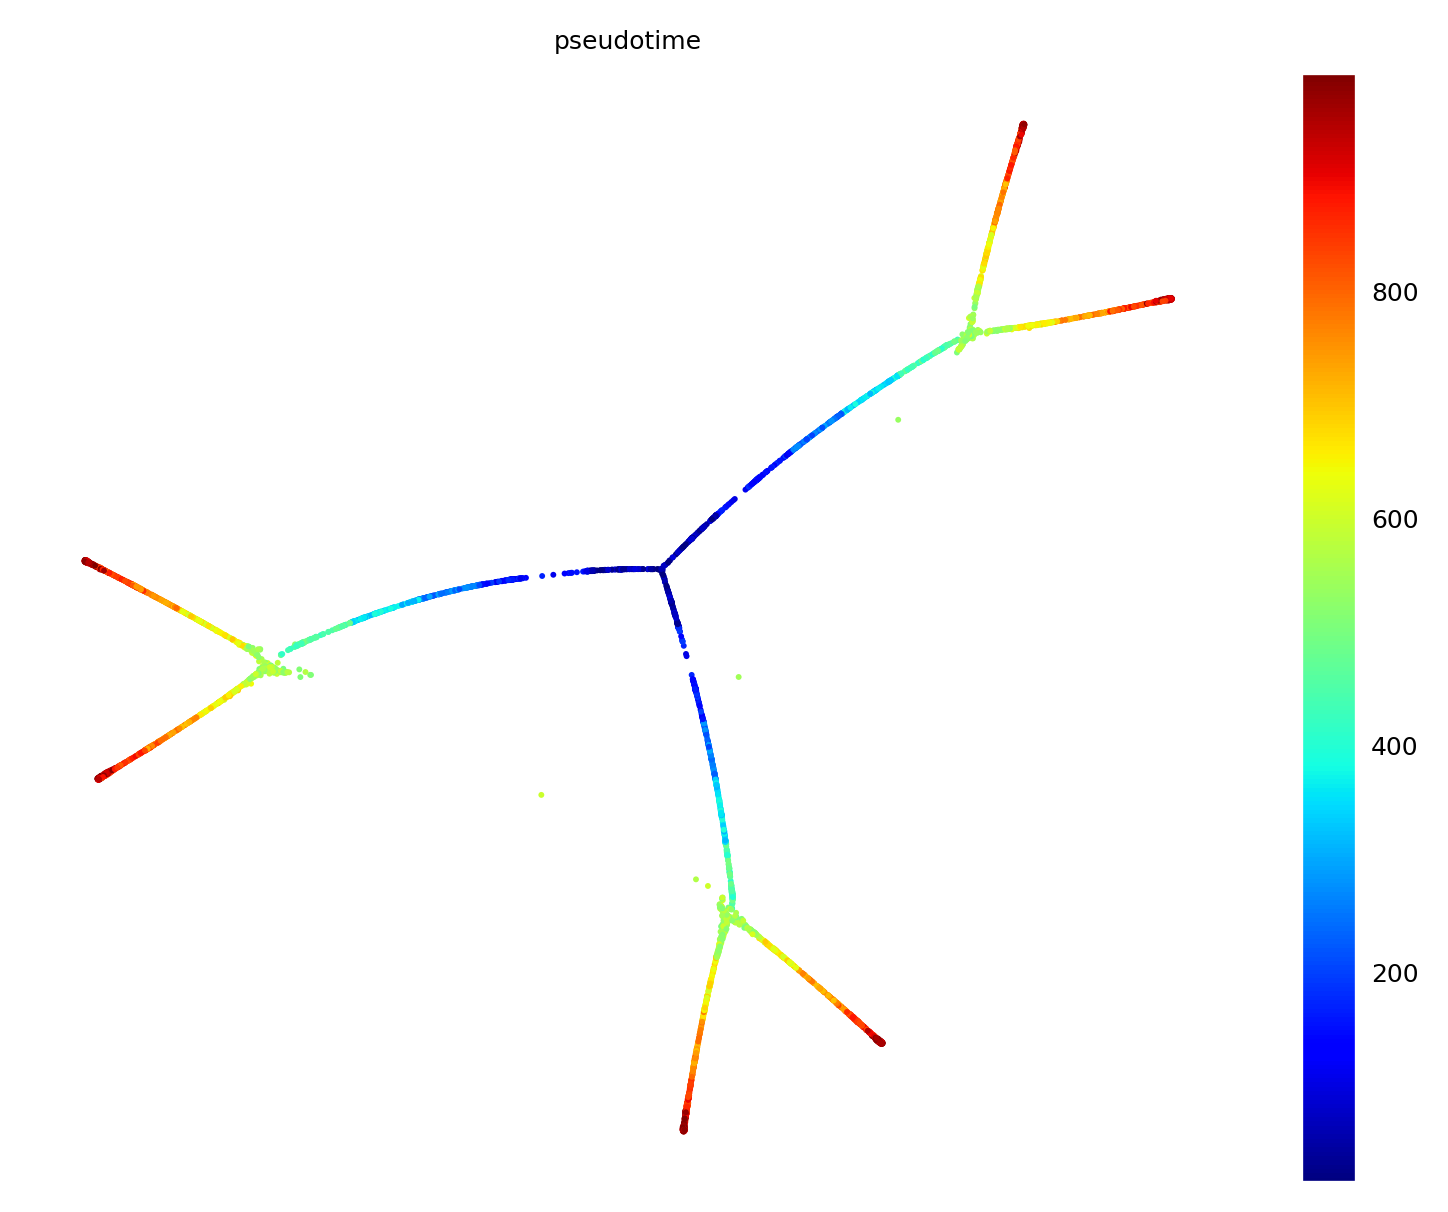

In [36]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='pseudotime', cmap='jet', marker_size=2)

Multimodal weights distribution looks as follows.

(<Figure size 1920x1440 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='modality0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>,
         <AxesSubplot:title={'center':'G'}>,
         <AxesSubplot:title={'center':'H'}>,
         <AxesSubplot:title={'center':'I'}>],
        [<AxesSubplot:ylabel='modality1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

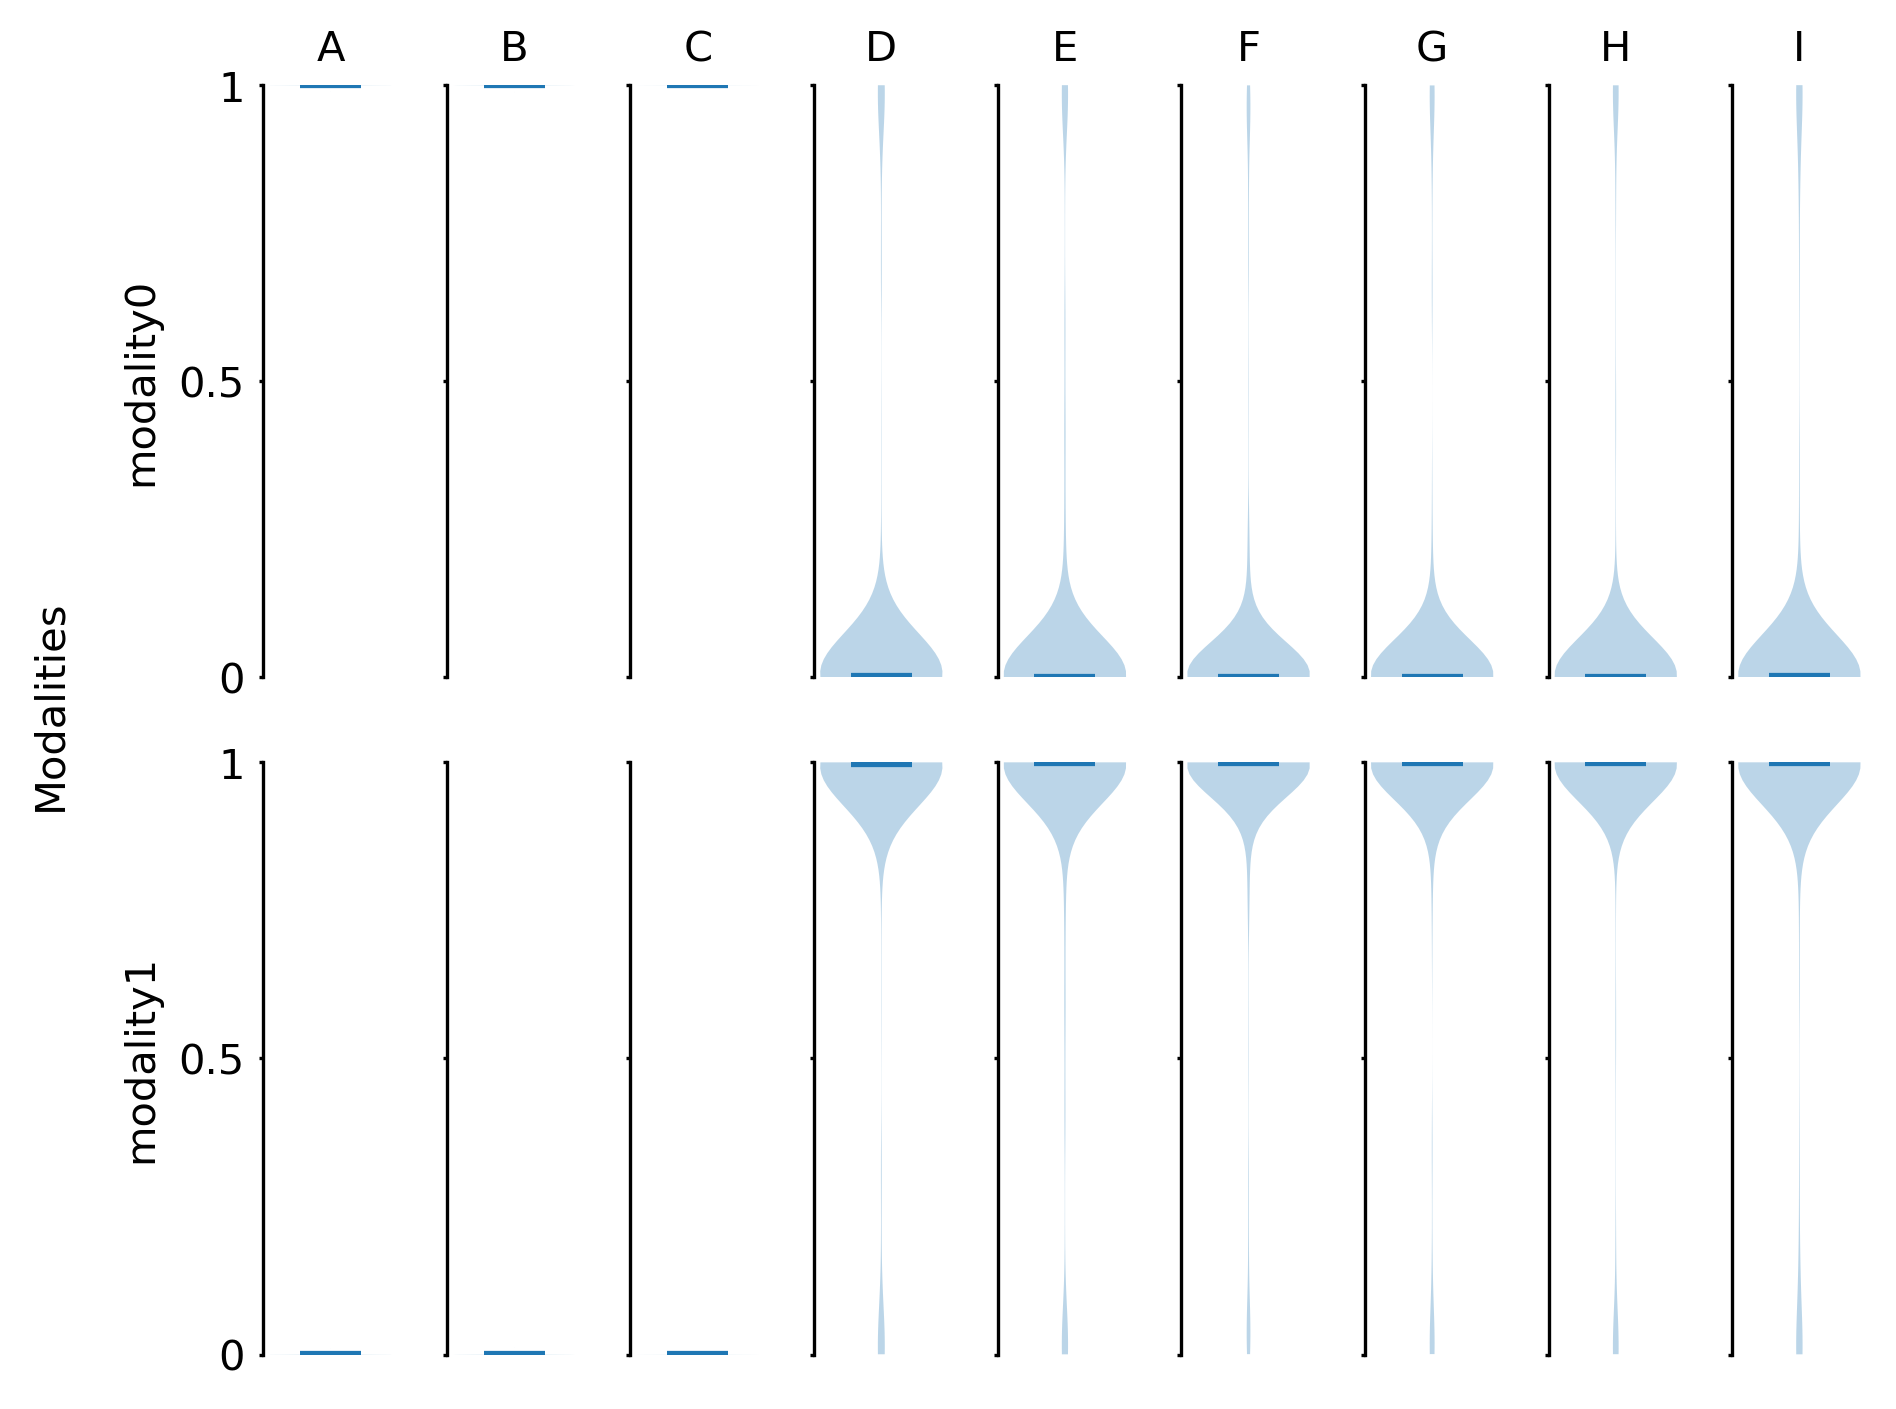

In [37]:
oci.pl.weights(adata, grouping_key='type', fontsize=10)

(<Figure size 1920x1440 with 4 Axes>,
 array([<AxesSubplot:title={'center':'modality0'}>,
        <AxesSubplot:title={'center':'modality1'}>], dtype=object))

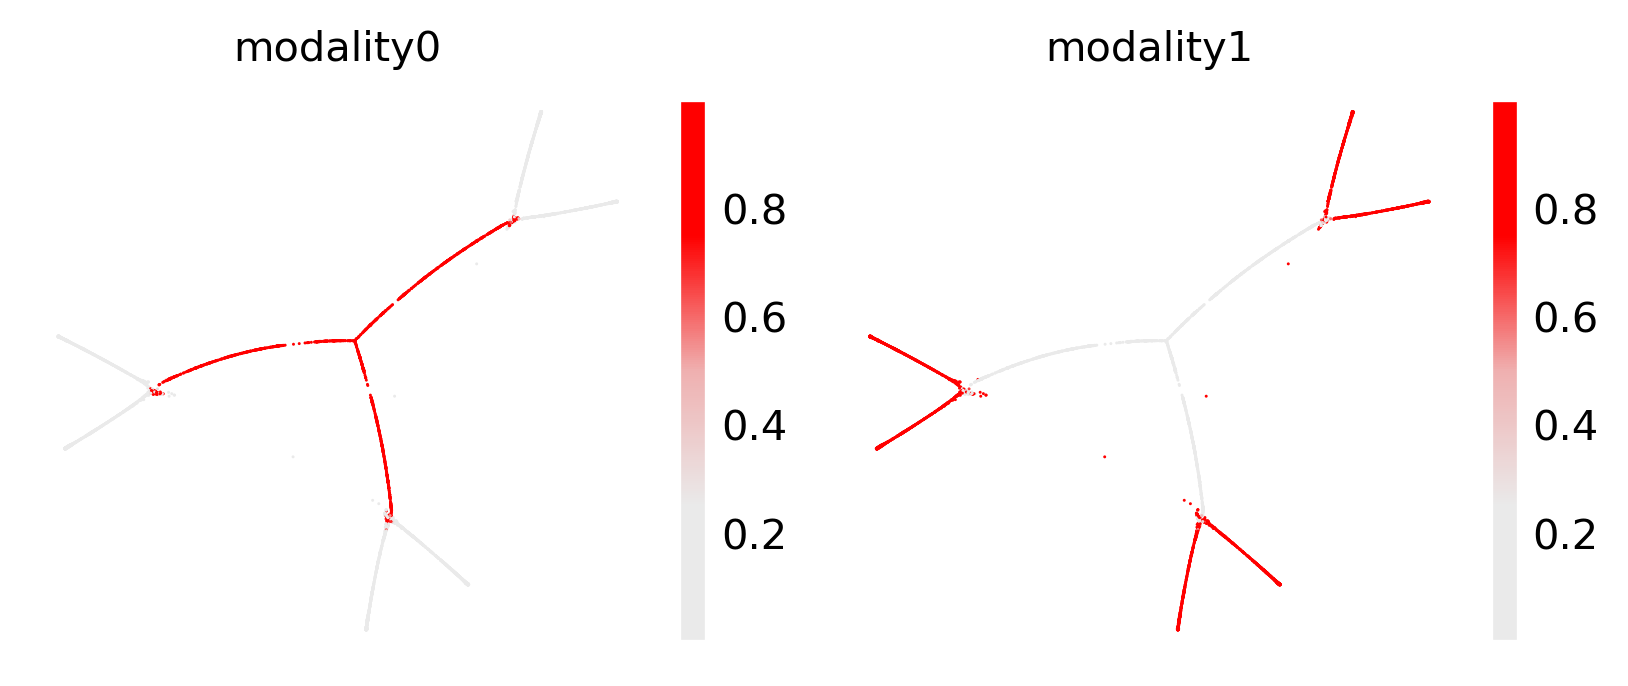

In [38]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='weights', cmap=weights_cmap, marker_size=0.5, fontsize=10)

It is a wrap-up of the first tutorial! Now you should better understand why joint multimodal visualizations unlock a new comprehension of data and how to build a basic Ocelli workflow.

In the following chapters, we will focus on single-cell data analysis!